# Fashion MNIST 
The MNIST dataset contains 70000 images of handwritten digits from 0-9. It is a very popular dataset and is commonly used to benchmark the accuracy of computer vision models. Some claim that for modern computer vision tasks the dataset is too easy to learn and is not a good indicator for how accurate a model really is. The Fashion MNIST dataset is a drop-in replacement for MNIST and is meant to be a much more difficult dataset to classify. 

From github.com/zalandoresearch

> _Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. We intend Fashion-MNIST to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits._

For more information see - https://github.com/zalandoresearch/fashion-mnist

### Import modules and create CAS session
- In this code we import the needed modules and cas action sets
- We assign values for the cashost, casport, and casauth values 
- These are then used to establish a CAS session named 's'
- Documentation to [Connect and Start a CAS Session](http://go.documentation.sas.com/?cdcId=pgmsascdc&cdcVersion=9.4_3.3&docsetId=caspg3&docsetTarget=home.htm&locale=en)

In [1]:
%matplotlib inline
import swat as sw
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict

from casplt import plot_imgs

# Start CAS session
sw.options.cas.print_messages = False
# remove username and password
s = sw.CAS('localhost', 5570, 'sas','pwd')
s.loadactionset('image')
s.loadactionset('deepLearn')
s.loadactionset('sampling')

sns.set()

class_dict = OrderedDict([('class0','T-shirt/top'), ('class1','Trouser'), ('class2','Pullover'), ('class3','Dress'), 
                          ('class4','Coat'),('class5','Sandal'), ('class6','Shirt'), ('class7','Sneaker'), 
                          ('class8','Bag'), ('class9','Ankle boot')])

[actionset]

 u'sampling'

+ Elapsed: 0.00205s, sys: 0.00204s, mem: 0.199mb

### Load data into CAS and partition
- Load and decode images recursively into CAS. 
- Single channel images divided into 10 diffferent classes

In [2]:
# Load training images recursively 
s.image.loadimages(casout=dict(name='train', blocksize='128',replace=True), recurse=True, decode=True, 
                   distribution="RANDOM", labelLevels=1, path='/some/dir/mnist_fashion_train_png/')
# Load test images recursively 
s.image.loadimages(casout=dict(name='test', blocksize='128',replace=True), recurse=True, decode=True,
                   distribution="RANDOM", labelLevels=1, path='/some/dir/mnist_fashion_test_png/')
s.image.summarizeimages(imagetable='train')['Summary']

,Column,png,minWidth,maxWidth,minHeight,maxHeight,meanWidth,meanHeight,mean1stChannel,min1stChannel,max1stChannel,mean2ndChannel,min2ndChannel,max2ndChannel,mean3rdChannel,min3rdChannel,max3rdChannel
0,_image_,59907.0,28.0,28.0,28.0,28.0,28.0,28.0,73.002725,0.0,255.0,0.0,0.0,0.0,0.0,0.0,0.0


##### Partition training images into train and validation sets using stratified sampling with an 80/20 split
- Training set has PartInd = 0 
- Validation set has PartInd = 1

In [3]:
s.stratified(display={"names":"STRAFreq"},
                 output={"casOut":{"name":"train", "replace":True}, "copyVars":"ALL"},
                 samppct=20, partind=True, seed=10,
                 table={"name":"train"},
                 outputTables={"names":{"STRAFreq"},"replace":True})

,ByGrpID,NObs,NSamp
0,0,59907,11981


##### Create CASTable (in-memory table) from loaded images and shuffle 

In [4]:
trainTbl = s.CASTable('train', replace=True)
testTbl= s.CASTable('test',replace=True)
trainTbl.shuffle(casout=dict(name=trainTbl,replace=True), table=trainTbl)
testTbl.shuffle(casout=dict(name=testTbl,replace=True), table=testTbl)

[caslib]

 u'CASUSER(sas)'

[tableName]

 u'TEST'

[casTable]

 CASTable(u'TEST', caslib=u'CASUSER(sas)')

+ Elapsed: 0.0189s, user: 0.00993s, sys: 0.00899s, mem: 22.1mb

### Summerize CASTables and examine partitions  
- Validate equal distribution of each class in both training and validation sets
- Out of ~ 60k images 80% should have _PartInd_ values of 0 and 20% have value 1
- For each class we should see ~4800 images with _PartInd_ values of 0 and ~1200 _PartInd_ values of 1

##### Additional column _PartInd_ now included in CASTable

In [6]:
trainTbl.columninfo()

,Column,Label,ID,Type,RawLength,FormattedLength,NFL,NFD
0,_dimension_,,1,int64,8,12,0,0
1,_resolution_,,2,varbinary,16,16,0,0
2,_imageFormat_,,3,int64,8,12,0,0
3,_image_,,4,varbinary,784,784,0,0
4,_size_,,5,int64,8,12,0,0
5,_path_,,6,varchar,65,65,0,0
6,_label_,,7,varchar,6,6,0,0
7,_type_,,8,char,3,3,0,0
8,_id_,,9,int64,8,12,0,0
9,_PartInd_,Partition Indicator,10,double,8,12,0,0


##### Frequncy of observations for both _PartInd_ values 

In [8]:
trainTbl.freq(inputs='_PartInd_')

,Column,NumVar,FmtVar,Level,Frequency
0,_PartInd_,0.0,0,1,47926.0
1,_PartInd_,1.0,1,2,11981.0


##### Number of observations is ~ 4800 for each class where _PartInd_ = 0 

In [9]:
trainTbl.groupby(['_label_']).query('_PartInd_ = 0').summary()

,_label_,_label__f,_key_
0,class0,class0,class0
1,class1,class1,class1
2,class2,class2,class2
3,class3,class3,class3
4,class4,class4,class4
5,class5,class5,class5
6,class6,class6,class6
7,class7,class7,class7
8,class8,class8,class8
9,class9,class9,class9


##### Number of observations  is ~ 1200 for each class where _PartInd_ = 1

In [10]:
trainTbl.groupby(['_label_']).query('_PartInd_ = 1.0').summary()

,_label_,_label__f,_key_
0,class0,class0,class0
1,class1,class1,class1
2,class2,class2,class2
3,class3,class3,class3
4,class4,class4,class4
5,class5,class5,class5
6,class6,class6,class6
7,class7,class7,class7
8,class8,class8,class8
9,class9,class9,class9


### Plot sample images from each class
    Class Description
    0   T-shirt/top
    1   Trouser
    2   Pullover
    3   Dress
    4   Coat
    5   Sandal
    6   Shirt
    7   Sneaker
    8   Bag
    9   Ankle boot

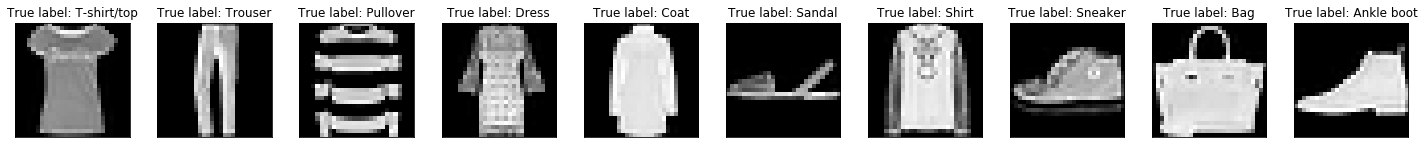

In [11]:
plot_imgs(trainTbl, images_per_class=1,font_size=12)

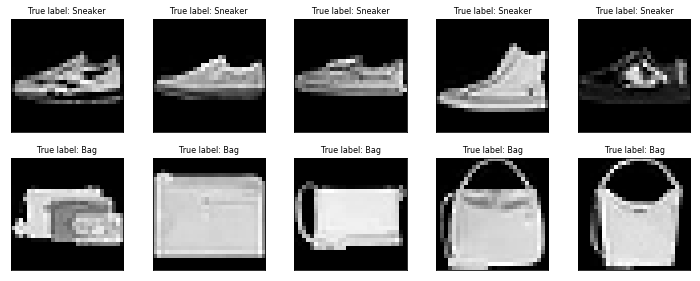

In [12]:
plot_imgs(trainTbl, class_list=[7,8], images_per_class=5, figsize=(10,4), font_size=8)

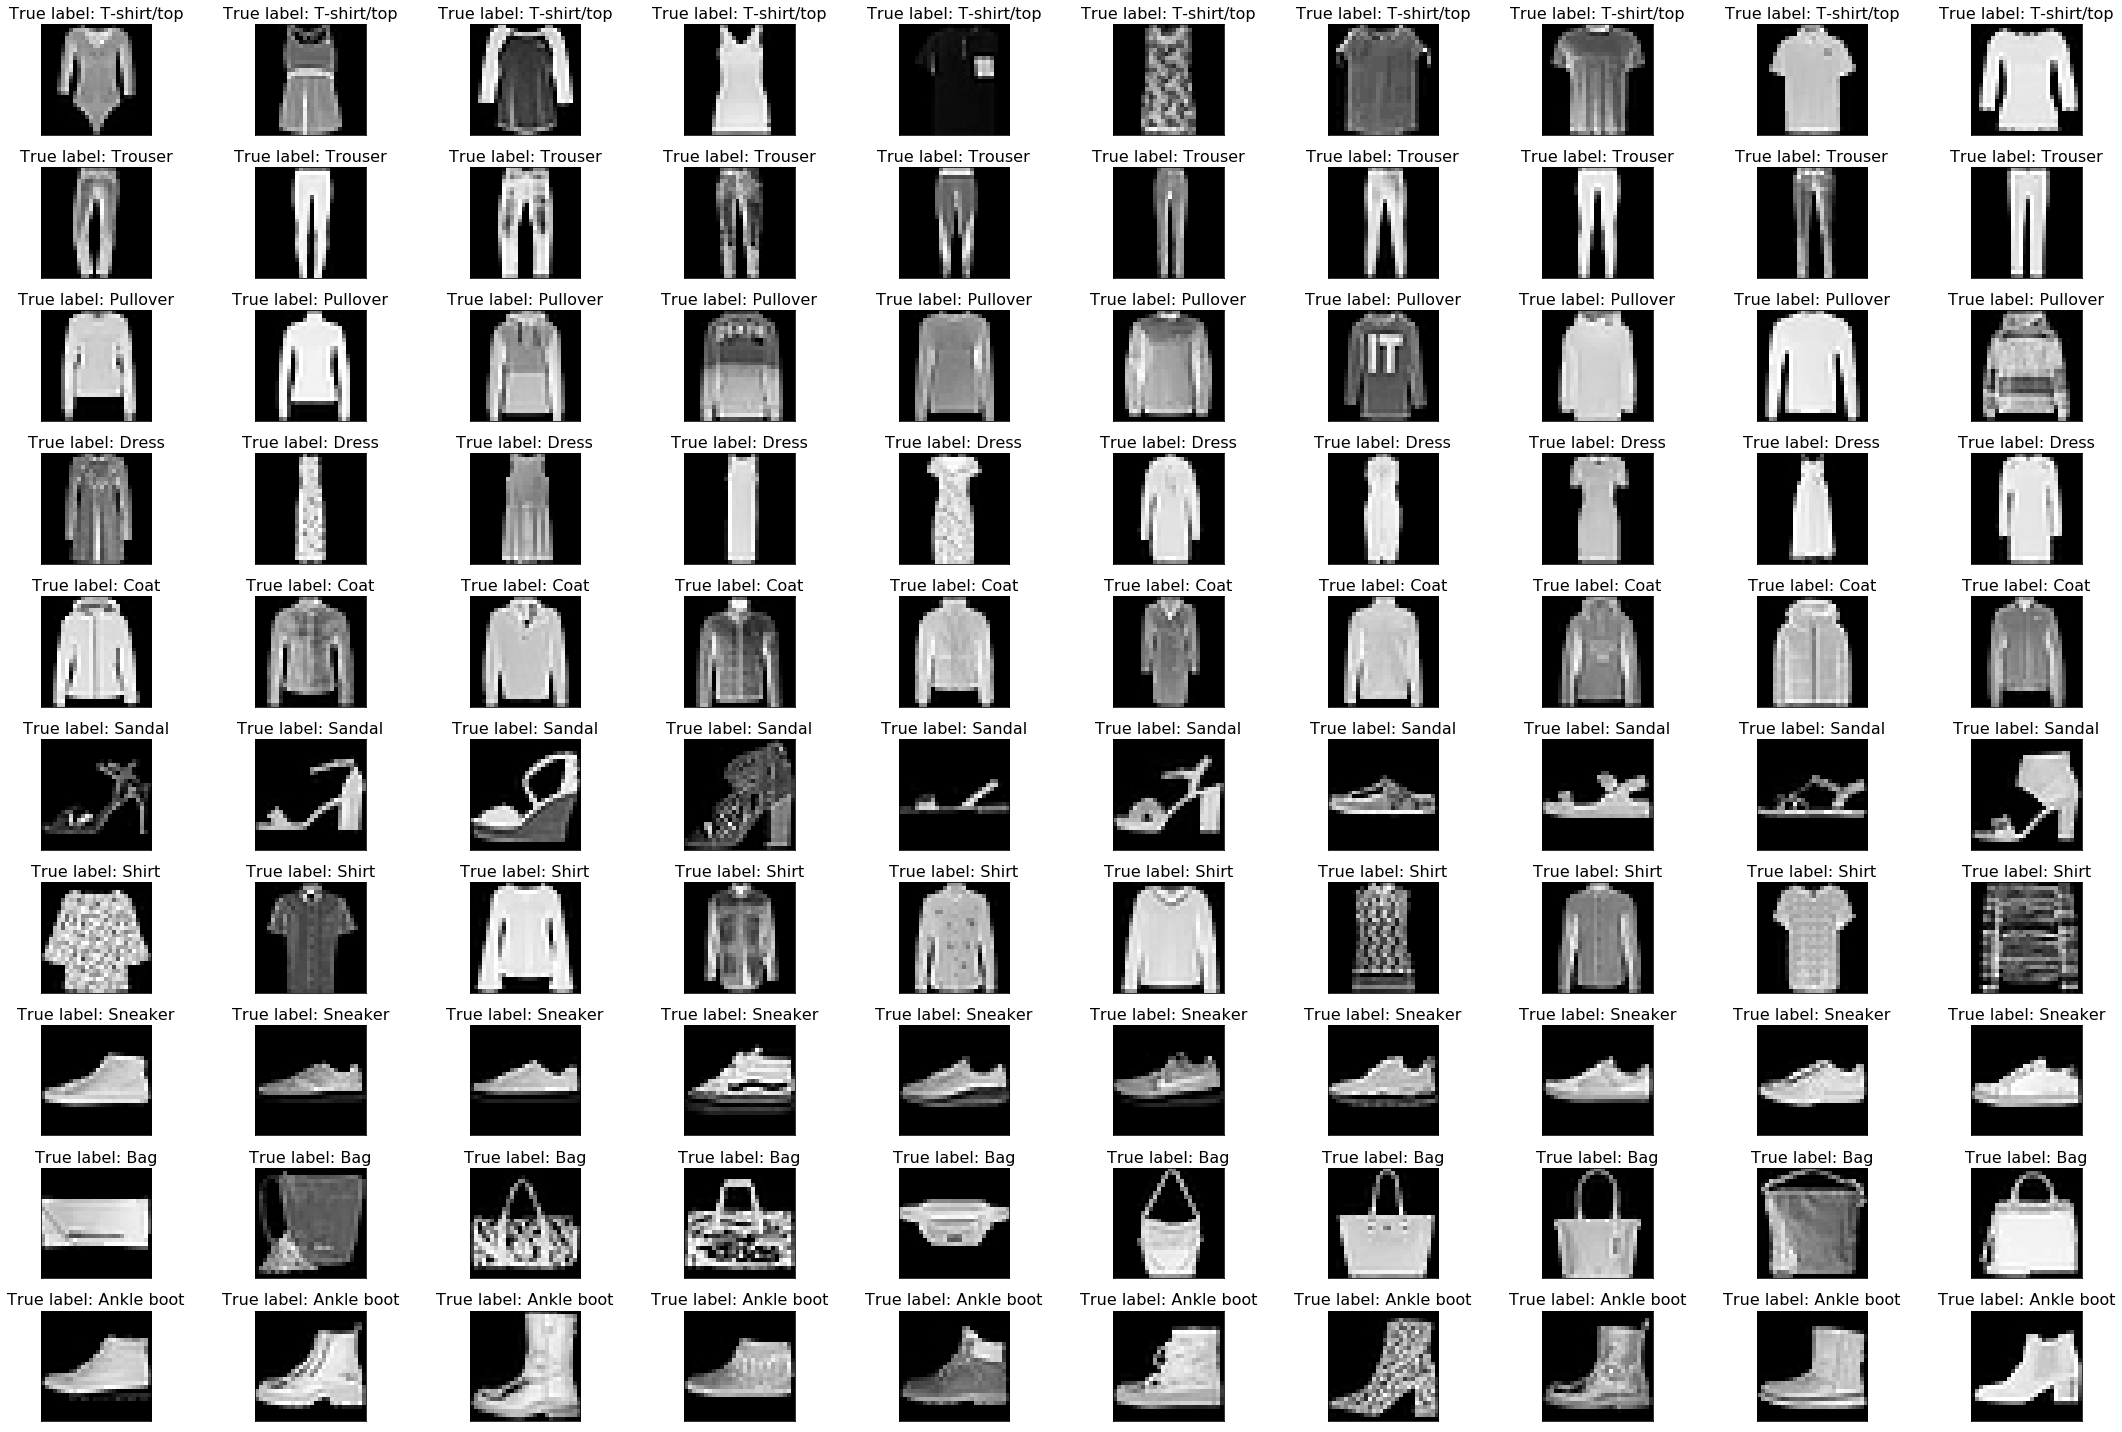

In [13]:
plot_imgs(trainTbl, images_per_class=10, figsize=(30,20), font_size=16)

### Create model architecture 

<img src='lenet_architecture.png', width=700, height=700>

Define the model architecture by subsequently adding layers to the model object. The model is a type of ConvNet called LeNet which consist of mainly 3 types of layers - convolution, pooling, and fully connected. The model can be made arbitrarily deep by repeating the sequence of convolution to pooling layers, but in this instance we only use 2 convolutional layers to keep the number of parameters down. 

As each layer is built you must specify some options and hyperparameters. These options and hyperparamaters are layer dependent. For example the first layer, data, specifies the image dimensions as well as some image augmentation and normalization options. One option in the data layer is image standardization (std='STD') where an 'average' image created (0 mean, 1 std).

Following the input layer the first convolutional layer is created. Hyperparameters for this layer like number of filters, filter size, stride, weight initialization method, and activation function are assigned. Aside from the standard activation functions (tanh, relu, etc.) you can also [define your own activation functions](http://go.documentation.sas.com/?cdcId=pgmsascdc&cdcVersion=9.4_3.3&docsetId=casdlpg&docsetTarget=n05z4t47t5g95xn18sp25xwdqs70.htm&locale=en#n0z6vluxdfvg0an1f2azd8y0b9f7), which has auto differentiation built in. 

From the convolutional layer define a max pooling layer which downsamples the output feature map from our convolutions. The reason pooling is important is to 

We repeat this one more time and then create our fully connected layer. We then output the classifications using softmax activation in order to get our predictions.

In [189]:
# This will create a empty Conv. Net.
s.buildmodel(model=dict(name='lenet',replace=True),type='CNN')

# Add first layer. This is an input layer that reads in 1 channel (grayscale) 28x28 pixel images.
s.addlayer(model='lenet', name='data', replace=True,
          layer=dict(type='input',nchannels=1, width=28, height=28, scale=0.004, std='STD'))

# Add 1st convolutional layer. 
s.addLayer(model='lenet', name='conv1', replace=True, 
           layer=dict(type='convolution',act='relu', nFilters=32, width=5, height=5, stride=1, init='xavier'), 
           srcLayers=['data'])

# Add 1st max pooling layer.
s.addLayer(model='lenet', name='pool1', replace=True,
           layer=dict(type='pooling', width=2, height=2, stride=2, pool='max'), 
           srcLayers=['conv1'])

# Add 2nd convolutional layer
s.addLayer(model='lenet', name='conv2', replace=True,
           layer=dict(type='convolution',act='relu', nFilters=64, width=5, height=5, stride=1, init='xavier'), 
           srcLayers=['pool1'])

# Add 2nd max pooling layer
s.addLayer(model='lenet', name='pool2', replace=True, 
           layer=dict(type='pooling',width=2, height=2, stride=2, pool='max'), 
           srcLayers=['conv2'])

# Add fully connected layer
s.addLayer(model='lenet', name='fc1',  replace=True,
           layer=dict(type='fullconnect',n=1024, act='relu', init='xavier',dropout = 0.4), 
           srcLayers=['pool2'])

# Add softmax output layer
s.addLayer(model='lenet', name='outlayer', replace=True,
           layer=dict(type='output',n=10,act='softmax', init='xavier'), 
           srcLayers=['fc1'])
s.modelInfo(model='lenet')

,Descr,Value
0,Model Name,lenet
1,Model Type,Convolutional Neural Network
2,Number of Layers,7
3,Number of Input Layers,1
4,Number of Output Layers,1
5,Number of Convolutional Layers,2
6,Number of Pooling Layers,2
7,Number of Fully Connected Layers,1


### Train lenet

In [190]:
sw.options.cas.print_messages = True

In [193]:
trainTbl.shuffle()
testTbl.shuffle()

[caslib]

 u'CASUSER(sas)'

[tableName]

 u'_T_EZKKKL2E_R7TBWJUZ_F4JAAMDDES'

[casTable]

 CASTable(u'_T_EZKKKL2E_R7TBWJUZ_F4JAAMDDES', caslib=u'CASUSER(sas)')

+ Elapsed: 0.038s, user: 0.0218s, sys: 0.0162s, mem: 22.1mb

In [1]:
lenet = s.dltrain(model='lenet',
              table=dict(name=trainTbl, where='_PartInd_ = 0.0'),
              validTable=dict(name='train', where='_PartInd_ = 1.0'),
              seed=54321, 
              nthreads=2,
              gpu=dict(devices={0,1}),
              inputs=['_image_'], 
              target='_label_', 
              modelWeights=dict(name='LeNet_Weights', replace=True),
              optimizer=dict(mode=dict(type='synchronous'),
                             miniBatchSize=64,
                             algorithm=dict(method='momentum',learningRate = 1e-2,),
                             maxEpochs=50, 
                             loglevel=1)
                 )
lenet

NameError: name 's' is not defined

### Score on test data 

In [195]:
s.dlscore(model='lenet',
          initWeights='LeNet_weights',
          table=testTbl, 
          copyVars={'_label_','_image_'}, 
          layerImageType='jpg',
          layerOut=dict(name='layerOut', replace=True),
          casout=dict(name='LeNet_scored', replace=True)
          )

[ScoreInfo]

                          Descr         Value
 0  Number of Observations Read          9982
 1  Number of Observations Used          9982
 2  Misclassification Error (%)      7.593669
 3                   Loss Error       0.31955

[OutputCasTables]

          casLib          Name  Rows  Columns  \
 0  CASUSER(sas)      layerOut  9982      197   
 1  CASUSER(sas)  LeNet_scored  9982       15   
 
                                             casTable  
 0      CASTable(u'layerOut', caslib=u'CASUSER(sas)')  
 1  CASTable(u'LeNet_scored', caslib=u'CASUSER(sas)')  

+ Elapsed: 9.55s, user: 61.5s, sys: 4.51s, mem: 143mb

In [196]:
sw.options.cas.print_messages = False

### Examine misclassifications
Examine what caused the bulk of the misclassifications. This is done by plotting our actual values vs. predicted values as well as examine the frequency of each classes missclassifications. From there we can look at a few different cases of correct and incorrect predictions.

##### Plot frequency of misclassifications for each class

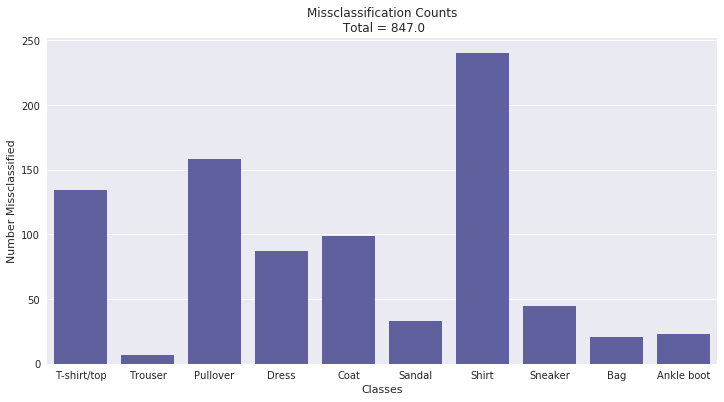

In [139]:
missedCount = []
for i in range(len(c)):
    missed = 0
    for j in range(len(c)):
        if i != j:
            missed = missed + c[i][j]
    missedCount.append(missed)
    
plt.subplots(figsize=(12,6))
ax=sns.barplot(x=class_dict.values(), y=missedCount, color='blue', saturation=0.25)
plt.title('Missclassification Counts\n Total = '+str(np.sum(missedCount)))
plt.xlabel('Classes')
plt.ylabel('Number Missclassified')
plt.show()

##### Build a crosstab

In [20]:
cmr = s.crosstab(table='LeNet_scored', row='_label_', col='_DL_PredName_')
cmr['Crosstab']

,_label_,Col1,Col2,Col3,Col4,Col5,Col6,Col7,Col8,Col9,Col10
0,class0,866.0,2.0,18.0,12.0,3.0,0.0,88.0,0.0,11.0,0.0
1,class1,0.0,986.0,1.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0
2,class2,15.0,2.0,842.0,12.0,69.0,0.0,58.0,0.0,2.0,0.0
3,class3,23.0,8.0,3.0,912.0,30.0,0.0,23.0,0.0,0.0,0.0
4,class4,2.0,0.0,26.0,22.0,901.0,1.0,47.0,0.0,1.0,0.0
5,class5,0.0,1.0,0.0,0.0,1.0,964.0,0.0,23.0,1.0,7.0
6,class6,110.0,4.0,37.0,27.0,56.0,0.0,760.0,0.0,6.0,0.0
7,class7,0.0,0.0,0.0,0.0,0.0,13.0,0.0,948.0,0.0,32.0
8,class8,1.0,2.0,3.0,4.0,2.0,0.0,6.0,3.0,979.0,0.0
9,class9,0.0,0.0,0.0,0.0,0.0,2.0,0.0,21.0,0.0,977.0


##### Plot a confusion matrix

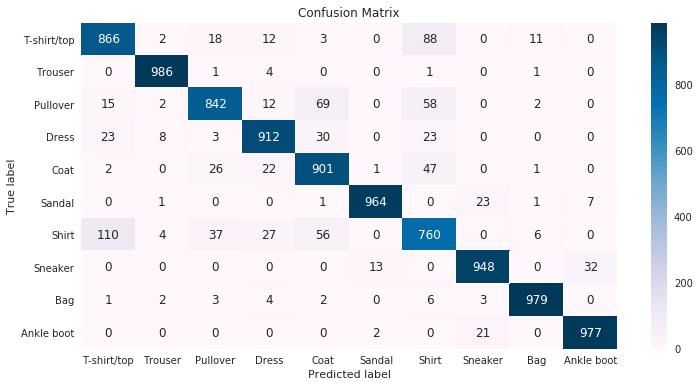

In [168]:
c=cmr['Crosstab'].values
c=c[:,1:].astype('float')
plt.subplots(figsize=(12,6))
ax = sns.heatmap(c,annot=True, fmt="g", cmap='PuBu',
                 yticklabels=class_dict.values(), xticklabels=class_dict.values())
plt.title('Confusion Matrix')
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAArsAAAGDCAYAAAArotjfAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDIuMS4xLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvAOZPmwAAIABJREFUeJzs3Xl4TOf7x/H3TDIhiRBBRFA7QeyxJyIh1kRE7apFS+yU2MVWS5W2WvvSqqK0FLFEEdVai6BqV0LsQRISiSwzk98ffubbtBJZncy4X9c11yVnzjn5PHlmjnueec45qpSUlBSEEEIIIYQwQWqlAwghhBBCCJFbpNgVQgghhBAmS4pdIYQQQghhsqTYFUIIIYQQJkuKXSGEEEIIYbKk2BVCCCGEECZLil0hxFsvISGBgQMHUq9ePYYPH57l/Wzfvp1+/frlYDJlfPTRR2zdulXpGEIIkSNUcp1dIYSx2LFjB6tXr+bGjRtYW1vj5OTEwIEDcXFxydZ+t23bxrp169i4cSPm5uY5lDbnHD9+nPfff5+WLVuyePFiw/LLly/j6+tLgwYNWLt27Wv3s3DhQsLDw5k/f35uxhVCiDwl7x3VhRDiFVavXs2KFSuYPn06rq6uaDQaDh06xP79+7Nd7N67d4+yZcvmyUL3JTs7O/7880+io6MpXLgwAFu3bqVs2bI59jtSUlJISUlBrZYv/YQQpkOOaEKIPC82Npavv/6aKVOm0KpVK6ysrNBoNHh6ejJu3DgAkpKSmDVrFq6urri6ujJr1iySkpKAFyOjzZo149tvv6Vx48a4urry888/A/D111+zZMkSdu/eTZ06ddi0aRMLFy4kICDA8Pvv3LlDlSpV0Gq1AGzZsoUWLVpQp04dPD092b59u2F5jx49DNudPn2ad999l3r16vHuu+9y+vRpw3O9e/dmwYIFdO/enTp16tCvXz+ioqLS/BtoNBpatGhBcHAwADqdjuDgYHx8fFKtN3PmTNzd3albty6dOnUiNDQUgIMHD7J8+XJDOzt06GDI8eWXX9K9e3dq1arF7du36d27N5s2bQJg6tSpDBs2zLD/efPm8cEHHyBfCgohjIUUu0KIPO/MmTMkJibi5eWV5jpLly7l7NmzBAUFsX37ds6dO8eSJUsMzz9+/JjY2FgOHjzIrFmzmDFjBk+fPmX48OH4+/vTtm1bzpw5Q5cuXdLNEh8fz8yZM1m5ciVnzpxh48aNVK1a9T/rPXnyBH9/f3r37s3x48fp27cv/v7+REdHG9bZuXMnc+bM4dixYyQnJ/Ptt9+m+7s7duzItm3bADh8+DCVK1emePHiqdapUaMG27Zt48SJE3h7ezNixAgSExNp1qxZqna+LNABgoKC+OSTTzh9+jSOjo6p9jd+/HiuXr3Kli1bCA0NZfPmzcydOxeVSpVuViGEyCuk2BVC5HlPnjyhcOHC6U4z2LFjB0OGDKFIkSLY2dkxZMiQVAWdubk5Q4YMQaPR4O7ujpWVFTdu3MhSHrVazd9//01CQgL29vZUqlTpP+v89ttvlClTho4dO2Jubo63tzfly5fnwIEDhnU6depEuXLlyJ8/P23atOHSpUvp/t66devy9OlTwsLC2LZtG76+vv9Zx9fX1/C36tevH0lJSa9tp5+fH5UqVcLc3ByNRpPqOUtLSz777DM+/fRTxowZQ2BgIA4ODunuTwgh8hIpdoUQeZ6trS3R0dGGaQSv8vDhw1Sjko6Ojjx8+DDVPv5ZLFtaWhIfH5/pLFZWVnz55Zds3LgRV1dXBgwYwPXr11+b52WmiIgIw8/FihXLdJ4OHTqwfv16jh8//sqR7m+++Ya2bdtSr149XFxciI2NTTWa/ColSpRI9/latWpRqlQpUlJSaNu27WszCiFEXiLFrhAiz6tTpw4WFhaEhISkuY69vT337t0z/Hz//n3s7e2z9PssLS1JSEgw/Pz48eNUz7u5ubF69WoOHz5M+fLlCQwMfG2el5n+Pe0gs3x9ffnhhx9wd3fH0tIy1XOhoaGsWrWKBQsWcPLkSUJDQ7GxsTHMr01r6sHrpiSsX7+e5ORk7O3tWbVqVbbyCyHEmybFrhAiz7OxsWH48OHMmDGDkJAQnj9/TnJyMr///jufffYZAO3bt2fp0qVERUURFRXF4sWL/3PyVkZVrVqVkydPcu/ePWJjY1m+fLnhucePHxMSEkJ8fDwWFhZYWVm98uoF7u7u3Lx5kx07dqDVagkODubatWs0b948S5leKl26NGvXrmXkyJH/eS4uLg4zMzPs7OzQarUsWrSIZ8+eGZ4vUqQId+/eRa/XZ/j33bhxgwULFjBv3jw+++wzVq1a9drpFkIIkZdIsSuEMAr9+vVj/PjxLFmyhMaNG9O8eXPWr19Py5YtARg8eDDOzs506NCBDh06UL16dQYPHpyl39W0aVPatWtHhw4d6NSpEx4eHobn9Ho93333HW5ubjRo0ICTJ08ybdq0/+yjcOHCLFu2jNWrV9OwYUNWrVrFsmXLsLOzy1Kmf3JxcXnlCLGrqytubm60bt0aT09P8uXLl2qKQps2bQBo2LAhfn5+r/09Wq2WMWPG0L9/f5ycnChbtiwff/wxY8eONVzpQggh8jq5qYQQQgghhDBZMrIrhBBCCCFMlhS7QgghhBDCZEmxK4QQQgghTJYUu0IIIYQQwmRJsSuEEEIIIUxW2vfeFBmm6fm50hFyRfK3I5SOkOP0ern4iLFQq9O/0YHIO2LjTPMyZDbWFkpHyHGmegGm190YxWjlzxtlmlnjHtnaXndsQw4lyZq88VcUQgghhBB5k8q4JwIYd3ohhBBCCCHSISO7QgghhBAibUY+TUSKXSGEEEIIkTYjn8Ygxa4QQgghhEibkRe7xp1eCCGEEEKIdMjIrhBCCCGESJvM2RVCCCGEECbLyKcxSLErhBBCCCHSJsWuEEIIIYQwVSojv6OlcZfqJqZM0YJsH+vHw5VDuL1kIF/18cTs/19gapWK6V2aEr7Yn6hvhnFydm8KWeUzbFvOvhDbAjoS9c0w7i8fzJwezZRqRoYlJSUxcWogHm1aUqdxfXy7duL3w4eUjpVp6zf+QOeeXanZoA4TpkxK9dzuvb/QvpMP9Zo2wLtTB0IO7FcoZeal1a4//zpLv4Ef0ci9CU083Bg5ZhQPHz1SMGn2BEwYh2sLd+o2aUBrn3Zs2rJZ6UjZ9uTpE4aMHE7thi54tGnJjuCdSkfKknv37zF89FA8WjejtXdL5n7+KVqtFoCToSfo1acH7i1d8e3szZZtPyucNmtMoa/WbfyBd3t2pUb9OowP/N+xIik5meEBH+PZthVOtZ05fvKEgimzzxT66m0lI7t5yMJ+LXj0NJ7Sg5dha5WPXyZ0ZpBXbRbtOcPUzk1oXNkRt6k/cOtxLNVLFSEh+cVBX2OmZveEzizb9yc9F+5Ep0+hskNhhVvzelqtlhIODqz9Zg2OJUrw+6GDjBwzih2bt1GqZEml42VYsWLFGNjfn8NHj5CYmGhYHvEwgnGTxrPoy4W4NXXl98MH+XjsaEJ27aGIXREFE2dMWu2KiYmh67tdcG3cFDMzM2bOncWkaZNZuXi5gmmzzv/D/sye/gkWFhZcvxHG+x/2oapTVZyrVVc6WpbNmD0TjUbDkQO/c+nyZfyHDcapshOVKlZUOlqmfDp/NnaF7fhl+z5in8UyZMQgNm/5ic6duhAwYTTDh4ygk++7XLx0kYHD+uNc3ZnKlaooHTtTTKGv7IsVY9BH/hw+doSEhMRUz9WrXZcPevVm5JhRCqXLOabQV1lm5NMYcjV9dHQ0vr6++Pr60rRpU9zc3Aw/JyUlpbvt8ePH8ff3f+VzkyZN4tq1a6987rvvvuP58+eplq1YsYLt27cTEhKS5nZ5Qdlihdh0/CqJyToinsaz56+bVCtVBFvrfAxvW5eBK/dy63EsABfuRJKYrAPgA/fq3I9+xoLgU8QnaklM1nHu9mMlm5IhVlZWDBs0hFIlS6JWq/Fwb06pkqW4cOmC0tEypVULL1p6tMDW1jbV8gcREdjYFKSZqxsqlYrmbu5Y5rfk1u3bCiXNnLTa1czVjTZerSlQoACWlpb07NaT03+eUShl9lWqWBELCwsAVCoVKpXKaProVeLj49kbso8RQ4ZhbWWNS916eLp7ELRzu9LRMu3evXu09PQiX758FC1SlCaNmnD9RhhPY2KIi3tG+zbtUalUVK9WnXJlyhF2I0zpyJliKn3VqoUXLT1bYFso9bHCQqPhg/d6U69OXdRqM4XS5QxT6assU6mz91BYriYoXLgwQUFBBAUF0b17d/r06WP4+eV/Llkxa9YsKr7ik5ROp+P777//T7F76NAhXF1d83yxu3D3abo1roKlhTmOhQvQulY59py9iXPpomh1ejo1rMztJQO58HlfBnnVNmzXsKIj4Y9i2DG2E/eXDyZkclecSxdVsCVZ8zjyMTfDb1Kxgml8SnauVp3y5crz628H0Ol0hBzYj4WFBVUqV1Y6Wo4KPX3K6Pts2qwZ1GpYj7a+3hQrWgx3NzelI2XZzfBwzMzNKVe2rGGZU5UqXLued499aenRrSd7Q/aQkPCch48ecuTYEZo0akIRuyK09mrD9l3b0el0/HXuLPcf3Kd2rTpKR84UU+orU/fW95VKlb2HwvLENIYTJ04wa9Ys4MXIyrp164AXn6SGDx/O1atXqV69OvPnz0elUtG7d2/Gjh1LjRo1qFOnDt26dePo0aO0atWKhw8f8sEHH2Bra8vatWt59uwZycnJ3Lx5k19//ZUTJ06wdOlSFi5cSFxcHFOnTuX58+e88847zJ49m0KFCtG7d2+qVKnCyZMn0el0zJ49m5o1a+b63+HQ5Tt81KImUd8Mw9xMzfe/nyco9Brdmzhha52fyg6FqTRiFZUcbNkzqQtX70ez/3w4Je0K0Lxaafw+38av528xrG1dfh7ti/Po1STr9LmeOyckJycTMGEcfj6+VChXXuk4OcLMzAxfbx/GTBxLYlISGo2GLz/7HCtLK6Wj5ZgrV6+wdMVSFn25UOko2TJt0hQCx0/izNk/ORF6EgtN1j+MKy3+eTwFrK1TLbMpUIC4+HiFEmVd3dp12Rq0BXcvN3Q6Hd7tfGjezAOA1l5tmDlnBp8vmAfA+ICJOBR3UDJupplSX5m6t76v8sDobHbkifTffvstU6ZMISgoiPXr15M/f34ALl68yMSJEwkODubOnTucOnXqP9vGx8dTs2ZNtm/fztChQ7G3t2fNmjWsXbsWgKNHj9K4cWPq1q2Lp6cnY8eOJSgoiHfeeYexY8cSEBDAjh07qFy5MosWLTLsNyEhgaCgIKZOncrEiRNz/W+gUsHOce+y9cTfFOr7NcUHLMbWOj9zejTjedKLubkztx4jIVnLuduP+enYFdrWLgfA8yQtR67cZc/ZmyTr9HyxM5QiBSypWjLvzwsF0Ov1jJ00AY1GQ+CESa/fwEgc/eMY87/6gjUrV/PXiTN8v2o1gTOmcunKZaWj5YjwW7cYMHQQE8aMx6VuPaXjZJuZmRkudevxICKCDT/9qHScLLOytOJZXFyqZc+exWFtZVwfsvR6PcM+HoKHuyeH9h8lZPcBYmJi+HrJV9y8eYOJU8YzPfATjv1+gh/Xbeb79d9x+IhxneBqKn31NpC+Mm55otitW7cun376Kd9//z2xsbGYm78YcK5ZsyYODg6o1WqcnJy4e/fuf7Y1MzOjdevWae770KFDNGv23ysTxMbGEhsbS4MGDQDw8/MjNDTU8Hz79u0BqF+/Ps+ePSMmJiZbbXwduwKWlClWkCV7z5Ck1RH1LIE1By/QpnY5zt16caZ7Ssr/1k/5xw/nbj8i5d87NBIpKSlMmhrI48jHLPx8ARqNRulIOeby1cu41K2Hc3Vn1Go1NarXoJZzTY4dP6Z0tGy7e+8e/QZ+xKD+/vh6d1A6To7S6XTcumO8c3bLlimDTqvlZni4Ydnlq1eMbqpJTMxTHkQ8oFvnblhYWGBbyJYO7X05cvQw18Ku8U7pMjRu1AS1Wk3ZMmVxbeLGkT+OKB07U0ylr94Gb31fyZzdzFu/fr3hRLWIiAgGDBjAzJkzSUhIoEePHly/fh0g1bxeMzMzdDrdf/aVL18+zMzSnvj+119/ZWkKgupfc0z+/XNOi4x9TtjDJ/i3rI2ZWkUhq3z0dqvGuVuPCHv4lEOX7jChY0MszM1wcrSja2Mndp15cTLGD4cv0bBiCTyd30GtUjGibV0exz7n0t3IXM2cE6bOnMH1G2EsW7jYMKJvbLRaLYmJieh1OnR6HYmJiWi1WpyrOXPqzGnDSO7Fy5cIPXOKKpWMY85uWu2KeBhBX/9+9Oreg+5duikdM1siIyPZtTuYuPg4dDodh44cZtfuYBo3bKh0tCyzsrLCq4UXXy9ZSHx8PKfOnGb/b78a3YcSW9vClHQsyeYtm9BqtcTGxrJz9w4qVayEU2Unbt+5xcnQE6SkpHDnzm0OHTlEpQqVlI6dKabSVy+PFTq9Dv0/jhXw4hKTL6/mkpycTGJiYqrBGmNhKn2VZTJnN/N69epFr169DD/funWLKlWqUKVKFc6fP8+NGzewsbHJ0r6tra2Ji4vDzs6Ov//+m/LlyxuK4ZfPAdjY2FCwYEFCQ0NxcXEhKCiI+vXrG/YTHBxMo0aNCA0NxcbGJst5MqPrl9v5vLcHYzrUR6dP4cCFWwSs/Q2A9xbtYsWAVkSsGMzDmHimbTrCgQu3ALh6P5oPlgSzuF9L7AtacebmQzrN35bn5+vevXePHzf/hIWFBa6e7obl0wOn0aG9t4LJMmfZquUsXr7U8POOXTsZ4j+IoQOHMNR/MCPHfMzjyEjsCtvh368/TRs3VTBtxqXVLpVKxe07d1i8bAmLly0xPH/q6EklYmaLSqViw6YfmTprBnq9npIlHJk4dhwtmnsqHS1bpk6azMSpgTTxaIatbSGmTQo0yssjfTb7cz7/ah5r1n+HWm1G/Xr1GTUigCJ2RZgycRrzvvyMBxH3KWBdgDat2tGxg5/SkTPNFPpq6crUx4rt/3+sGDZoCG18vbl3/x4AHw1+cYWlkF17jOryki+ZQl9lWR4Ync0OVcob+oi1cOFCrKys+PDDD//z3CeffMLx48dRqVRUqlSJTz/9lDNnzvDtt9+yfPmLa3fOmDEDZ2dnOnXq9J8T1M6c+d9lj9auXcu6deuwt7enefPmFC5cmE6dOgFw6tQpAgMDsbCw4Ouvv051glrp0qWZM2eO4QQ1JycnTp48iVarfe0Japqen+fwXytvSP52hNIRcpxeb3wjCm8rtZHfsedtEhuX/qUkjZWNtfGeqJgWYxxVzYjc/vZVMfnzxHUEMG+bveska3d/kUNJsuaNFbtK6Nu3L3PnzsXe3j5T2/2zmM4IKXaNhxS7xkOKXeMhxa7xMNX/8qXYzV3m7QKytb02eH4OJcmavPFXzCWrV69WOoIQQgghhHEz8g8TJl3sZtXLy5YJIYQQQrz1jHzOrhS7QgghhBAibUZe7Bp3eiGEEEIIIdIhI7tCCCGEECJtMmdXCCGEEEKYLCOfxiDFrhBCCCGESJsUu0IIIYQQwmQZ+XXPjbtUF0IIIYQQIh0ysiuEEEIIIdKkkmkMwhRvqwtg5tFb6Qg5TnfANG8YYqJ3ABVGwhRvq2uqTPa2uiJ3SbErhBBCCCFMlpF/SDLuUl0IIYQQQoh0yMiuEEIIIYRIm0xjEEIIIYQQJkuKXSGEEEIIYbKMfM6uFLtCCCGEECJtRj6ya9zphRBCCCGESIeM7AohhBBCiLQZ+ciuFLtCCCGEECJtMmdXCCGEEEKYLCl2hRBCCCGE6TLuYte4J2G8RZ48fcKQkcOp3dAFjzYt2RG8U+lIGeJUxpF9CycTte8brmz6ko7uLobnurRoxPkN83kS8i3nfpiHbzOXVNuWc7Rn+/wxPAn5lojdK/h0SM83HT9L1m1YT6ceXXF2qc34wIlKx8lxN8PDqdmgDmMmjlM6So4w1vdWekyxTab6vpK+Mh6m2Fdvizw3shsdHU2fPn0AePz4MWq1Gjs7OwA2bdqEhYWFgumUM2P2TDQaDUcO/M6ly5fxHzYYp8pOVKpYUeloaTIzU7P1swCWbw2h9YhZuNepRtC8AOp9MIG4hES+nzoEv7Hz+eWPs7RrUocfZ42gfKfhPIqOQWNuxp6vJrLk5710n/w1Or2eyqVLKN2kDLEvZs/g/v4cOnqExMQEpePkuBlzZlKjurPSMXKMMb63XscU22Sq7yvpK+Nhin2VYUY+jSHPjewWLlyYoKAggoKC6N69O3369DH8/LLQTUlJQa/Xv7FMWq32jf2uV4mPj2dvyD5GDBmGtZU1LnXr4enuQdDO7Yrmeh2nMo44Fi3Mgo3B6PUpHDh1gaN/XeW9tm6UKmbHk9g4fvnjLADBR88Q9zyRCiWLA9CnvTv3HkezYGMw8QmJJCYlc+76LSWbk2GtWnrR0rMFtraFlI6S43b9EkxBGxsaNWikdJQcYazvrfSYYpvANN9X0lfGw1T7KsNU6uw9FKZ8ggwKDw+nXbt2jB49mvbt2/Po0SOCgoLw8fHB29ubL774AnhRmLq4/O/r8F27djFp0iTDv729venQoQO9e/c2rD9nzhw6d+6Mj48PmzZtAuDo0aP07t0bf39/fHx83nBrU7sZHo6ZuTnlypY1LHOqUoVr168pFyqLVCoVzuVLE3o5jEvh9/BxrYdarcK3mQuJycn8de1FQdvQuRLh9x+x64txROxewf7FgThXKK1w+rfbs2fP+HrJIsYHjFU6So4xpffWS6bYJlMlfWU83vq+Uqmy91BYnpvGkJ6wsDDmzp1LjRo1ePDgAV999RWbN2/GxsaGvn37cuDAAdzc3NLcftGiRaxdu5aiRYsSExMDwI8//kiRIkXYvHkzSUlJdO3alaZNmwJw/vx5du3ahaOj4xtpX1rin8dTwNo61TKbAgWIi49XKFHGXAm/z8PopwT08mHBxmA86lWjWZ2q/HbqAnp9Cut2H2Td9KHkt9CQpNXSbdJXxCckAlCqmB3N61Wj45j57A89z/Bubdk6dzTVuo8mWatTuGVvp68WL6SzXyccijsoHSXHGOt7Kz2m2CZTJX1lPKSvjJvRjOwCvPPOO9SoUQOAs2fP0rBhQ+zs7NBoNHh7e3Py5Ml0t69bty7jxo1j06ZNhmkQR44c4eeff8bX15cuXboQExNDeHg4ALVr11a80AWwsrTiWVxcqmXPnsVhbWWlUKKM0ep0dBr3Be2a1uHerqWM6tGeTfv/4M6jKFrUd+bTIT3xHPIJ+Zv1xmPwDFZM6E+tSmUAeJ6YxOGzV/jlj7Mka3V8vn4nRQrZULVsSYVb9Xa6dPkSx44f44P33lc6So4y1vdWekyxTaZK+sp4SF+psvlQllGN7FpaWr52HbVaTUpKiuHnxMREw79nzpzJ2bNnOXDgAJ06dWLr1q2kpKQwbdo0GjdunGo/R48ezdDvexPKlimDTqvlZng4Zcu8KAYvX71CxQp5f1L8ueu38Bw8w/DzoRXTWRt8kFqVynDoz8ucuhwGQOilME5cuEaL+s6c/Tucv67fokmNKkrFFv9yIvQkd+/dw7NNS+DF/DWdXs/17tfZsnGzwumyzpjfW2kxxTaZKukr4/HW91UemIqQHUY1svtPtWrV4vjx40RHR6PVatm1axcNGjRArVZTqFAhbt68iV6vZ9++fYZtbt++Te3atRk5ciQFCxYkIiICV1dXfvjhB8NJaGFhYSQk5K2zR62srPBq4cXXSxYSHx/PqTOn2f/br/h6d1A62mvVqPAO+Sw0WOazYFTP9pQoYst3u34n9FIYrrWcDCO5tSuXxbW2E+f+f87u+l8O08i5Ii3qO6NWqxjRvS2Pn8Ry6eZdJZuTIVqtlsTERPQ6PTqdnsTERMVPcsyuru92Ye/O3Wz98We2/vgz3bp0w92tGauWrFA6WrYY83srLabYJjDN95X0lfEw1b7KMJmzqwwHBwdGjBjB+++/T0pKCh4eHjRv3hyAgIAAPvzwQ4oUKUL16tVJSkoCYPbs2dy9e5eUlBSaNm1K5cqVqVChAvfv36djx44A2NnZsWTJEqWalaapkyYzcWogTTyaYWtbiGmTAo3icifvtXXlQx8PNObmHD57mdYjZpOUrOXgmUtM/2YzP80eSfHChXj0JIY5a4LYd+IcAFdv3ef9aYtZMvZD7AsX5PSVm3QcO98o5usuXbmcRcv+9xravmsHQwcOZtigIQqmyh5LS8tU33RYWVqRzyKf4bKAxsxY31vpMcU2meL7CqSvjIkp9lXGKV+wZocq5Z/f+YusSTDuT6xpMfPorXSEHKc7sFbpCLnCFN/FeWAwQAghlJU/b4xJavouy9b2yasH5lCSrMkbf0UhhBBCCJE3GfnogxS7QgghhBAibVLsCiGEEEII0yXFrhBCCCGEMFVGPrJrtJceE0IIIYQQpuG7776jffv2eHt7M2rUKBITE7l9+zZdunTBy8uLkSNHGq6ulZSUxMiRI/Hy8qJLly7cuXMn3X1LsSuEEEIIIdKmUmfv8RoRERF8//33/Pzzz+zcuROdTseuXbuYP38+ffr0Yd++fRQsWJDNm1/cxGjTpk0ULFiQffv20adPH+bPn5/u/qXYFUIIIYQQ6cj92wXrdDoSEhLQarUkJCRQrFgx/vjjD1q3bg2An58f+/fvB+DXX3/Fz88PgNatW3Ps2DHSu5KuzNkVQgghhBBpUuXynN3ixYvTr18/PDw8yJcvH02bNqV69eoULFgQc/MXpaqDgwMRERHAi5HgEiVKAGBubo6NjQ3R0dFp3uhIRnaFEEIIIYRinj59yv79+9m/fz+HDh3i+fPnHDp0KMf2L8WuEEIIIYRIm0qVvcdrHD16lFKlSmFnZ4dGo6FVq1acPn2amJgYtNoXd6l98OABxYsXB16MBN+/fx8ArVZLbGwshQsXTnP/Mo0hB+j1JnivVkzz1roa/+zd8jCvSlzqr3SEHPfcRG/DbWWpUTpCjjPVvrLMI7dqFUJxuTyNwdHRkbNnz/L8+XPy58/PsWPHcHZ2pmHDhuzZs4f27duzdesTNT+dAAAgAElEQVRWPD09AfD09GTr1q3UqVOHPXv20KhRo3SnWsjIrhBCCCGESEfunqBWq1YtWrdujZ+fHz4+Puj1erp168aYMWNYvXo1Xl5ePHnyhC5dugDQuXNnnjx5gpeXF6tXryYgICD99Cnpnb4mMkQfn6x0hFyhVhv3RaRfRUZ2jUdCommOFsrIrvGQkV2huDzyGrQYtC5b2yctfS+HkmSNjOwKIYQQQgiTlTc+MgghhBBCiLzJyG8XLMWuEEIIIYRIhxS7QgghhBDCVMnIrhBCCCGEMFlGXuzKCWpCCCGEEMJkyciuEEIIIYRIh3GPjUqxK4QQQggh0mbk0xik2BVCCCGEEGkz8mLXuMelTdj6jT/QuWdXajaow4QpkwzL7967S9U6ztRrUt/wWLLCOO8KlpSUxMSpgXi0aUmdxvXx7dqJ3w8fUjpWhpQpasP2Ud48XPIRt7/qy1e9m2H2rzvOvde0CslrhtLPvZph2ai2dTgzqwdRywZwdf77jGpb501Hz7C0XoN//nWWfgM/opF7E5p4uDFyzCgePnqkYNLM+2XfL3Tq5kfj5o3wedeb03+eBmBL0BY6dPahiUdjhowczMNHDxVOmjVPnj5hyMjh1G7ogkebluwI3ql0pCz5cNCHNHCrT+PmjWjcvBG+XToYntvw0w+069iWph5N6PlBD878fx8aG1Ppq38y5mN7ekyxr94WMrKbRxUrVoyB/f05fPQIiYmJ/3n++MFjmJsbd/dptVpKODiw9ps1OJYowe+HDjJyzCh2bN5GqZIllY6XroXvu/Mo5jmlR6zG1iofv4zxZVCLGiza9xcAtlb5GOftwvk7kam2U6mg34oQ/rr9mAr2hQge04E7Uc/46fjfSjQjXWm9BmNiYuj6bhdcGzfFzMyMmXNnMWnaZFYuXq5g2oz74/gxvlr8FXNnzsW5mjOPH78o1ENPnWTRsoWsXLySd0qX4bMvPmPClAl8s/QbhRNn3ozZM9FoNBw58DuXLl/Gf9hgnCo7UaliRaWjZdr4gAl08u2Uatm583/x1eKv+HbZaqo6VWXTlk2MGjeKkOD9mJmZKZQ0a0ypr14y5mN7ekyxrzJORnZzTNWqVfH19cXb25vhw4fz/PnzdNcfP348v/zyCwC9e/fm3LlzbyLmG9GqhRctPVpga2urdJRcY2VlxbBBQyhVsiRqtRoP9+aUKlmKC5cuKB3ttcoWK8imE9dITNYR8TSePefCqVbSzvD8rC6NWbzvLJGxCam2+zz4DGfCH6HTp3D1wRN2nL5Bk0ol3nT8DEnrNdjM1Y02Xq0pUKAAlpaW9OzWk9N/nlEoZeYtXbWUAf0GUNO5Jmq1Gnv74tjbF+fgkUN4eXpRoXxFNBoN/fv15/SZU9y+c1vpyJkSHx/P3pB9jBgyDGsra1zq1sPT3YOgnduVjpZj7t2/R4XyFahWtRoqlQqfdt5EP4kmKjpK6WiZYqp9ZczH9rSYal9lmEqVvYfC8lSxmz9/foKCgti5cycajYaNGzcqHclAp9MpHSGVFu1a0bx1CyZOnUx0dLTScXLE48jH3Ay/ScUKef9T8sI9Z+nWqBKWFuY4Framdc0y7Dl3C4D65e2pV86e5QfOv3Y/rlUcuXg38rXr5WWhp08ZRZ/Bi/fxxUsXiX4STYfOPrT2acWn8+eQkPDiQ0lKSsr/Vv7/f18Lu6ZE1Cy7GR6Ombk55cqWNSxzqlKFa9eNqx0vLVzyNc1bufNB/w84eeokAE0bu6LX6Tl3/i90Oh3bdmyjSuUqFC1SVOG0mWNqfZUWYzq2p+Vt6as0SbGbO1xcXAgPD+fOnTt4e3sbln/zzTcsXLgw3W137tyJj48P3t7ezJs3D4ANGzYwd+5cwzpbtmxhxowZAAQFBdG5c2d8fX2ZMmWKobCtU6cOn376KR06dODMmbwxcmVrW5hN6zayP3gvm3/4kbi4OMZMGqd0rGxLTk4mYMI4/Hx8qVCuvNJxXuvQlXtUK2lH1LIBhC/oy+kbDwk6FYZapWLh+80ZsfZ3/lk3vcoUvwaoVSq+O3TpzYTOBVeuXmHpiqWMGTla6SgZEhkViVarJeTXEL5Z9i0b1/7I5SuXWbV6JU0aNWHf/n1c/fsqCQkJrPh2BSqVylAIG4v45/EUsLZOtcymQAHi4uMVSpR1I4eMYOeWXezduY93O77LiIDh3L5zG2tra1p4tqTvgL40cKvP8lXLCZwwBVUe+E81M0ypr9JibMf2tLwNfZU+VTYfysqTxa5Wq+XgwYNUrlw509tGREQwf/581qxZw7Zt2zh37hwhISG0bt2akJAQw3rBwcG0a9eO69evs3v3bjZs2EBQUBBqtZodO3YAL762qFmzJtu3b8fFxSXH2pcd1lZWOFd3xtzcnKJFijJ5/CSOHDtKXFyc0tGyTK/XM3bSBDQaDYETJr1+A4WpVLAzwIetodcpNGAZxQevwtY6H3O6NmFQixqcu/2Y49cj0t3H4JY1eK+pEx2+2EGSVv+Gkues8Fu3GDB0EBPGjMelbj2l42RI/nz5AejepTvFihajsG1h3uvRm8PHDtOoQSMG9h9IwITRtPdrR4kSjlhbWVPcvrjCqTPHytKKZ/86Hjx7Foe1lZVCibKuhnNNrK2tsbCwoEP7DtSuWZvDRw+xdftWgnYE8fPGnzl5OJRZ02czfNQwozuh0JT66lWM7dieHlPvK1OXp85wSkhIwNfXF3gxstu5c2cePszcwevcuXM0aNAAO7sX8yd9fHw4efIkLVu2pHTp0vz555+UKVOGsLAw6tWrx/r16zl//jydO3c2ZChSpAgAZmZmtG7dOgdbmPNeDmTo9cZZMKWkpDBpaiCPIx+zcvEyNBqN0pFey846P2WKFmRJyDmStHqitAmsOXSJ6e824nrEU5o5OdKmZpkX6xbIT+0yRan1TlFGrD0IQB+3qoxpXw/P2Vu4G22cH1Lu3rtHv4EfMai/P77eHV6/QR5RsGBBitsXTzUC+M9/d+vcnW6duwMQfiucVatXUrG8cX31WrZMGXRaLTfDwylb5sXr8PLVK0b9FfJLKpWKlJQUrly9TDPXZpR5pywATRs3pWjRYpz96yxeLbyUDZkJptxXxnhsT48p91WGGNm3Jv+Wp4rdl3N2/8nc3DxVIfeqKxNkVLt27di9ezfly5fHy8vLcOD08/Nj9Oj/fg2bL18+xc7s1Wq16HQ69DodOr2OxMREzMzMuHDpIgVtbCjzThmexsQw67M5NHCpj42NjSI5s2vqzBlcvxHG6hWryJ8/v9JxMiTyWQJhD5/i7+nMF7vPUCC/ht6uTpy7Hcmw738jv+Z/b6tNw9qy5eR1vj14EYAejSvzSedGeH26jRuPYpRqQoak9RqMjIqkr38/enXvQfcu3ZSOmWkdvH3ZuGkDTRs1xdzcnPUb1+HWtBmJiYncvnObCuUr8CDiAZ/MmUHPbj0pWLCg0pEzxcrKCq8WXny9ZCEzp87g0pXL7P/tVzauWa90tEyJiY3h/IVz1KvjgpmZGXtC9nDqzCnGjhpLgQI2rFq9kh5de1DSsSR/nPiDW7fCja7wMJW+ehVjPLanx5T7KiPUUuzmriJFihAZGUl0dDTW1tb89ttvuLm5pbl+zZo1mTVrFlFRURQqVIhdu3bx3nvvAeDl5cWyZcu4ePEiY8aMAaBx48YMHjyYPn36UKRIEZ48eUJcXBwlFb48yrJVy1m8fKnh5x27djLEfxDlypTjy0VfERUVhXUBa5o0bMz8OfMUTJp1d+/d48fNP2FhYYGrp7th+fTAaXRo753OlsrrunA3n/d0Y0z7uuj0KRy4dIeAHw7xND6JpyQZ1kvS6olJSCLm+Ytl099tRJEC+Tk2rYthnR+OXmXImt/edBNeK63XoEql4vadOyxetoTFy5YYnj919KQSMTOtf7/+PHkSjW/XDuSzyIdXi1Z81OcjkpISmThlArfv3sbaypoO3r4MHjBE6bhZMnXSZCZODaSJRzNsbQsxbVKg0V0eSavVsmjZYm6G30CtNqNcmbJ8+dkCyrxTlndKl+HOndt8NOhDYmJjKG5fnMnjJ1OubDmlY2eaKfTVvxnzsT09pthXGWXktS6qlJTXnUbz5tSpU+eVJ4J9//33fP/99xQvXpzSpUtTsmRJhg0bxvjx42nevDlt2rShd+/ejB07lho1arBz506WL19OSkoK7u7uhsIWwN/fn2vXrrF//37DsuDgYJYvX45er0ej0TBlyhRq166dZp5/08cn58wfII9Rq4381f0KGn/jvAHH6yQu9Vc6Qo5LSNQqHSFXWFka99e5r/I8wTT7yjJ/nh8PEqYuj7wGLUdn7xJrzz9Xdrpbnip2jZUUu8ZDil3jIcWu8ZBiV4hckkdeg9YBO7K1fdx8nxxKkjV5468ohBBCCCHyJGMf+5JiVwghhBBCpMnYrmH9b1LsCiGEEEKINBn7yG6evKmEEEIIIYQQOUFGdoUQQgghRJpkGoMQQgghhDBZxj6NQYpdIYQQQgiRJhnZFUIIIYQQJsvYR3blBDUhhBBCCGGyZGRXCCGEEEKkSaYxCEz1hsumeCfp5OUDlY6QK8y7BCodIcclbJiudASRQRYaM6UjCCFykbFPY5BiVwghhBBCpMnYR3Zlzq4QQgghhDBZMrIrhBBCCCHSJNMYhBBCCCGEyTL2aQxS7AohhBBCiDTJyK4QQgghhDBZaiMf2ZUT1IQQQgghhMmSkV0hhBBCCJEmIx/YlWJXCCGEEEKkzdinMUixK4QQQggh0mTkta4Uu0IIIYQQIm3GPrIrJ6jlQUlJSUyeHkiLdl64uDbAr/u7HDxyCIBrYdfp0qsrjdyb0Mi9Cf0GfsS1sOsKJ866O3fvMmDIIBq4NcG1hTsz5sxCq9UqHStbAiaMw7WFO3WbNKC1Tzs2bdmsdKQMcSpVjH0zPyJy41QuLw/At1E1ADTmZvw4vifXVo1Fu2MO7s7lUm032s+NPxeNIPrHafy9agyj/dyUiJ9h4yaPx72VBw2aNaKdnzebt/5seO6PE3/g3cmHek3q02dAP+7dv6dg0qx78vQJQ0YOp3ZDFzzatGRH8E6lI2Xa23IcNIW+ehVTbJcptultYdQju1WrVqVy5cpotVrMzMzo2LEjffr0Qa027hpeq9PiUNyB71d9RwmHEhw8fJBR40YT9NNW7IsVY8G8L3Es4Yher+eHnzYQMD6AbT9tVTp2lsyYPRM7OzsOhRwgJjaWfgP788NPG3m/53tKR8sy/w/7M3v6J1hYWHD9Rhjvf9iHqk5Vca5WXeloaTJTq9ky+X1W7D5O6ynf4O5cjm2BH+AyYiE3H0Zz5GI4X28/wsZxPf+zrUqlou+Xm/jrxgMqlLBj94x+3H78lJ8O/aVAS16vf9+P+GTKDCwsLAi7EUYf/35UdXLC0cGREQEfMyNwGs2bNWfh0kWMHj+GDWvWKx0502bMnolGo+HIgd+5dPky/sMG41TZiUoVKyodLcPeluOgKfTVq5hiu0yxTRll5AO7xj2ymz9/foKCgti1axerV6/m4MGDLFq06D/rGdtIoZWlFUMHDqGkY0nUajXNmzWnlGNJLly6SEGbgpR0LIlKpSIlJQUztRm37txWOnKW3bl3h7atWpMvXz6KFS2KW5OmXLtunCM0L1WqWBELCwvgRSGoUqm4dTtv95FTqWI42tmwIOgwen0KB/4K4+ilcN7zqEOyVsfX249w5GI4On3Kf7adv+UgZ67fQ6fXc/XuY7Yfv0STqmUUaEXGVKzwr/5Bxe3bt9l3IISKFSrQ2uvF63Gw/yCu/H2FsBthCifOnPj4ePaG7GPEkGFYW1njUrcenu4eBO3crnS0THkbjoOm0lf/ZortMsU2ZYZapcrWQ2lGPbL7T0WKFOGTTz6hc+fODBs2jK1bt7J3717i4+PR6/WsW7eOVatWsXv3bpKSkvDy8mL48OHEx8czcuRIHjx4gF6vZ/DgwbRr14758+fz66+/YmZmhqurK+PGjVOsbY8jH3PzVjgVy1cwLGvYrDHxz1+0bdigoYply673e/UmeM9uGrjUJyYmhkNHDjN8iPG256Vps2awdXsQCQkJVHOqirtb3v5q/1VUQPUyxTO9nWu1sqz85XjOB8pBM+bMJGhHEAmJCVStUhU312Z8vfhrqlSqYljHytKK0qVKcy3sOuXLlVcwbebcDA/HzNyccmXLGpY5VanCydCTyoXKAaZ4HDTVvjLFdplimzIjD9Sr2WIyxS5A6dKl0el0REZGAnDx4kW2b9+Ora0thw8fJjw8nM2bN5OSksKgQYM4efIkUVFR2Nvbs2LFCgBiY2OJjo5m3759/PLLL6hUKmJiYhRrU3JyMmMnjcfX2zfVf7jHDx4j/nk8QTu241iihGL5sqt+3Xr89PNmXFwbodPp6OjjS0uPFkrHyrZpk6YQOH4SZ87+yYnQk1hoLJSOlK4rdx/x8GkcAZ2asSDoMB41K9DMuRy/ncvcqObUni1Rq1V8F3Iql5LmjCkTJjNp7AT+/OssJ0+dxEKjIf55PIVtC6dar0CBAsTFxSmUMmvin8dTwNo61TKbAgWIi49XKFH2mepx0BT7CkyzXabYpreJUU9jeJ2mTZtia2sLwJEjRzhy5AgdO3bEz8+PsLAwbt68SeXKlTl69Cjz5s0jNDQUGxsbbGxsyJcvHxMnTmTv3r3kz59fkfx6vZ7xgRPQaDRMHjfxP89bWVrRrXNXxk+ZSGRUpAIJs0ev19N/yEBaebbgzLGTHPvtMDGxMcxf8IXS0XKEmZkZLnXr8SAigg0//ah0nHRpdXrenbWWdvWrcPf7SXzc0ZVNh89x5/HTDO9jcPvGvOdZhw7TvyNJq8vFtDnDzMyMenXqEvEwgh83/4SVpRXP/lXYxj17hvW//oPL617VjmfP4rC2slIoUfaY8nHQ1PrqJVNslym2KTOMfRqDSRW7t2/fxszMjCJFigBgaWlpeC4lJYUBAwYQFBREUFAQ+/bto0uXLpQrV44tW7ZQuXJlFixYwKJFizA3N2fz5s20adOGAwcO8NFHH73xtqSkpDB5+hQioyL5at6XaDSaV66n1+tJSEgg4uHDN5ww+54+fcq9+/fp1b0nFhYWFLa1pVOHjhw8fEjpaDlKp9MZxXzCczcf4DlhJcV7fUK7qasp72DHyb/vZGjbPi3rMbazO60mreJupHLfhGSFTqvj9p3bVKhQgSt/XzEsj38ez+07d1J9bW4MypYpg06r5WZ4uGHZ5atXqFjB+E6iMfXjoCn11T+ZYrtMsU2ZoVJl76E0kyl2o6KimDp1Kr169UL1ir+sq6srP//8s+EryYiICCIjI4mIiMDS0hJfX18+/PBDLl68SFxcHLGxsbi7uzNx4kSuXLnyn/3ltumzZxB2I4zFCxanGlk++sdRLl6+hE6n49mzZ8z94jMK2hSkghHNKXypcOHClCpZig2bfkSr1RITE8O2HUFUrlRZ6WhZFhkZya7dwcTFx6HT6Th05DC7dgfTuGFDpaO9Vo2yDuTTmGOZT8MoPzcc7GxY8//TESzMzcineTHryUJjbvg3QA/32sx8vzVtAr/hRkS0ItkzKjIqkuA9u4mLj0en03H46BGC9+ymYYOGtPRowbVr19i7fx+JiYksXbmMypUqG9V8XQArKyu8Wnjx9ZKFxMfHc+rMafb/9iu+3h2UjpZppn4cNKW++idTbJcptikzjH1kV5WSkvLf06uNxL8vPebr60vfvn1Rq9Vs2bKF8+fPM2XKFMP6a9asYfPmF9c8tbKyYt68eYSHh/PZZ5+hVqsxNzdn2rRpFC9enMGDB5OYmAhAv3798PPzSzOHLi45R9t19949vLxbYWFhgZmZmWH5tElT0Wg0LFy6iAcRD8ifLz81nJ35eOhIqlSuks4es+ZNXMHt0uXLzJ73KVeuXkVtpqZR/YZMHj+BokWK5srve9UHoZwUFRXF8ICPuXz1Cnq9npIlHOndsxdd3+2Sq7/XvEtgtvcxt29b+rWqj8ZMzeGLNxmxfAfX77/4WvjaqrGULZ56PmuFD+cS/vAJf68aQ6kihUhM/t9VT9b/9idDlmzLVp6EDdOztf2rREVH8fHYUVy5ehV9ih5HhxL06t6LLp06A3Ds+DFmzZ3NvQf3qelcg1nTZlLSsWSOZjA3z/031pOnT5g4NZCjx45ha1uI0SM+xqedd679Pp0u5/8byQvHQTOz3P9P+k331Ztiiu1SpE3588apVXU+P5Ct7c+M9sihJFlj1MVuXpHTxW5eYeSXK36l3C52lZITxW5ekxvFbl7wJordNy03it284E0Uu0KkS4rdHJE3/opCCCGEECJPygtTEbJDil0hhBBCCJEmtXHXulLsCiGEEEKItBn7FEApdoUQQgghRJqMfWTX9M6UEEIIIYQQ4v9JsSuEEEIIIdL0Jq6zGxMTw/Dhw2nTpg1t27blzJkzPHnyhL59+9KqVSv69u3L06cv7uqZkpLCzJkz8fLywsfHhwsXLqSfP9t/ASGEEEIIYbLUquw9MmLWrFm4ubnxyy+/EBQURIUKFVixYgWNGzdm7969NG7cmBUrVgBw8OBBbt68yd69e/nkk0+YNm1a+vmz2X4hhBBCCGHCcntkNzY2lpMnT9K584sb/FhYWFCwYEH2799Px44dAejYsSMhISEAhuUqlYratWsTExPDw3RuFy7FrhBCCCGEUMydO3ews7NjwoQJdOzYkUmTJhEfH09kZCT29vYAFCtWjMjIF3f1jIiIwMHBwbC9g4MDERERae5fil0hhBBCCJEmdTYfr6PVarl48SI9evRg27ZtWFpaGqYsvKRSqbJ8CTQpdoUQQgghRJpeFppZfbyOg4MDDg4O1KpVC4A2bdpw8eJFihQpYpie8PDhQ+zs7AAoXrw4Dx48MGz/4MEDihcvnub+5Tq7OUDun248tDq90hFyReLGGUpHyHH5en2idIRcod04RekIOc5U31dmZmZKRxAiT8jt6+wWK1YMBwcHwsLCKF++PMeOHaNChQpUqFCBbdu2MWDAALZt20aLFi0A8PT0ZN26dbRv356zZ89iY2NjmO7wKlLsCiGEEEKINL2Jm0oEBgYSEBBAcnIypUuXZs6cOej1ekaOHMnmzZtxdHRkwYIFALi7u/P777/j5eWFpaUls2fPTnffqpSUlJTcb4KJS9AqnUBkkKmOQKkwvW8XZGTXeCQm6ZSOkCvyWcjIrlBY/rwxJum19HC2tt83yDWHkmRN3vgrCiGEEEKIPCmjN4bIq6TYFUIIIYQQaTL2qxlIsSuEEEIIIdIkI7tCCCGEEMJkvYkT1HJTmsXujz/+mO6G3bp1y/EwQgghhBBC5KQ0i93Q0NA0N1KpVFLsCiGEEEK8BUx2GsO8efPeZA4hhBBCCJEHGfsJaq/Nn5iYyKJFixg3bhwAYWFh7N+/P9eDCSGEEEII5alVqmw9lPbaYnfatGnExcVx/vx5AOzt7Vm0aFGuBxP/k5SUxMSpgXi0aUmdxvXx7dqJ3w8fUjpWjnjy9AlDRg6ndkMXPNq0ZEfwTqUjZVpSUhKB06fQsl0r6rs2pFP3zhw68r/+ef78OTPmzKSppxsNmzXm/Q8/UDBtxiQlJTF5eiAt2nnh4toAv+7vcvD/23T2r7N8OOgjGjVvQlNPN0aOHcWjR48UTpw2p1JF2TejD5HrJ3J56Qh8G1Y1POdZszznFw0j5sfJhHzSl3eKFTI817lpdQ59+hExP05m/8y+SkTPsnUb1tOpR1ecXWozPnCi0nGyLfxWOC5NXZgQOAGAlatX0rBZQ8Ojvmt9ajWoRfSTaIWTZp4pHAP/zdRefy+ZYl+9LV57NYZLly6xbds2jh07BkCBAgXQ6Uzzbjl5lVarpYSDA2u/WYNjiRL8fuggI8eMYsfmbZQqWVLpeNkyY/ZMNBoNRw78zqXLl/EfNhinyk5UqlhR6WgZptVpcSjuwJpVqynhUIKDhw8xalwA237aQknHkkybOR2dTseOn4MoVLAQl69cVjrya71s0/ervvv/Nh1k1LjRBP20laexMXTp1IWvGjfFzMyMmXNnMWnaZFYsXq507P8wU6vZMqEnK/aE0nraGtyrl2XbpF64jFpKVOxzNo3rzoDFQew8eYUZPT3ZENCVpuNWAhAd+5yvdhzDqWQxPGqWU7glmWNfzJ7B/f05dPQIiYkJSsfJttmfzaZ6teqGn/v37U//vv0NPy9ZsYRTZ05R2LawEvGyxRSOgf9maq+/l0yxrzLK2K/G8NqRXQsLi1Q/JyUlkdfvMPzo0SM+/vhjWrZsSadOnejfvz83btzI1D5iYmJYv359LiXMHCsrK4YNGkKpkiVRq9V4uDenVMlSXLh0Qelo2RIfH8/ekH2MGDIMaytrXOrWw9Pdg6Cd25WOlilWllYMGTiYko4v+qd5M3dKOZbkwqWLhN0I48DB35g2eSp2he0wMzNL9Z92XmVlacXQgUP+0abmhjY1a+pGG6/WFChQAEtLS3p168nps2eUjvxKTqWK4mhnw4LtR9HrUzhw7gZHL9/ivea18GtclYu3H/Lz0QskJmuZvvEANcs6UKVkUQD2/xXG5iMXuBcVo3ArMq9VSy9aerbA1rbQ61fO43bv3Y2NjQ0N6zd85fMpKSns2LWDDu07vOFk2Wcqx8B/M6XX30um2lcZZfLTGOrVq8fKlStJSkoiNDSUjz/+mObNm7+BaFmTkpLC0KFDadCgASEhIWzZsoXRo0cTGRmZqf3ExMSwYcOGXEqZPY8jH3Mz/CYVKxj3p8mb4eGYmZtTrmxZwzKnKlW4dv2acqFywOPIx9y8FU7F8hU4d+E8jiVKsGjZYpp6utGxqx979+9TOmKm/bNN/xZ6+hQVyxvPa1GFiurv2FOttD1nbzwwLI9PTOb6gyiqvWOvYDrxT8+ePWPJ8iUEjAxIc51TZ04RFR2Fl6fXG0yWM/UGdc8AACAASURBVEz1GGiK3va+Uquy91Daa4vdjz/+mMTERPLnz8+sWbNwcnJi+PDhbyJblvzxxx+Ym5vTo0cPwzInJyfq1avH3Llz8fb2xsfHh+DgYADi4uL44IMP8PPzw8fHh5CQEAA+//xzbt26ha+vL3PnzlWkLa+SnJxMwIRx+Pn4UqFceaXjZEv883gKWFunWmZToABx8fEKJcq+5ORkxk0aj693B8qXK09ERAR/X7uGTQEbDuz5lUnjJjJxyiSuh4UpHTXDkpOTGTtpPL7evpT/12vuytUrLFm5lICRoxVKl74rdx/z8GkcAX6umJup8apdgWbVy2CVz4IClhbExCemWj8mPhEbS4s09ibetEXLFuHXwQ+H4g5prrNj1w68PL2wsrJ6g8lyhikeA03V295XalTZeijttXN2LSwsGDp0KEOHDn0TebLt77//pnr1/35NvHfvXi5fvkxQUBDR0dF07twZFxcX7OzsWLx4MQUKFCAqKopu3brRokULRo8ezd9//01QUJACrXg1vV7P2EkT0Gg0BE6YpHScbLOytOJZXFyqZc+exWFthP9pwYv+mRA4EY1Gw6RxL07KyJcvH+bm5vh/NABzc3Pq16tPA5cGHP3jKBXK5/0PK3q9nvGBL15zk8elPtEk/NYt/IcNYmLAeFzq1lMoYfq0Oj3vztnAV/3bM8bPlVPX77HpyAUStVqePU/CxipfqvVtrPIR+zxJobTiny5fuczxE8f5af1Paa7zPOE5e/fv5av5X73BZP/H3n2HNXX2fxx/h8gWt4LoU9yjjirurSBqFUSt9bHDVmtbtdY96sKBo0+ttda9Wq21rVoVEdG69x7UutA6wI0KKkIkkvH7w1/TUkWQACcn/b565bqak5PD5859Er+5c59zso+9fQbaM+krdcuw2NXpdMyfP59Dhw4B0KBBA3r16qW6b9HHjx+nXbt2aLVaihQpQp06dTh16hRNmzZl+vTpHD16FAcHB+Li4rh3757ScZ9hNpsZPS6Ee/H3WDRnPo6OjkpHslopHx+MBgMxsbGU8vEBIPrCeVVOzzCbzYRMGMu9hHjmz5xr6Z+K5Ss8s67GBuYvZYbZbGbMhLHEJ8Qzf+a8NPvcjZs36dnnQ3p/1Iv2gbY9V/JUbBx+Y76z3N/7vw9ZtuM3zJh5r0VNy3I3Z0fKehXk7NU7SsQU/3D0+FFu3LpBq8BWwNORNZPJxKV3L7Fq+dMCeMfOHeTPl586teooGTXL7Okz0N792/vKFqYiWCPDaQyjRo0iLi6OYcOGMWzYMO7cucPIkSNzI1uWlC9fnjNnMn/gVkREBAkJCaxdu5bw8HCKFCmCXq/P+Im5bNykUC5ducz8WXNwcXFROk62cHNzI8A/gJlzZ6HT6TgedYLtu3YQbOPF0/OETpnI5StXmDNjdpr+qeVbi+JexVm0ZDEGg4ETv0Vx5NgRGjVoqGDazJkwJZTLVy4zZ0bafS7uThwf9P6At//7Fl072/6VFKv5eOLsmAdXJ0cGBzfCq6AH3++IYt2hc1R5pRgdG7yKs2MeQv7bnFMxcZy/8fTLroODBmfHPOTROuCg+ev/1cBgMKDX6zEZTRiNJvR6PQaDQelYL6Vzp85sDNvILz/+wi8//sKbnd6kSaMmzJ8137LO+sj1BLUNUs0XyH+yp8/Av7OH/e+f7LWvMkvtB6hpzBmcWuH1119n06ZNGS6zFWazmS5dutC5c2fLJY2jo6PZtm0bUVFRLFy4kIcPH/LGG2+watUqNm7cyNWrVwkJCeHQoUO8//77bN++HXd3dzp16sTOnTsz/qMpOfsmvnHzJn6vB+Dk5EQerdayfELIeNq3C8zRv53THjx8wKhxIRw4eJACBfIzZMAggtrmXJsMRlO2b/PmzZsEBLbGyckJ7d/6Z/zosQS2DeTipYuMDR3HhT/+oHjx4gzo25+Wfv7ZmkGTzXOibty8SUBgq+e0aRxXr11lzoK5uLq6pnnO8f1HszWD8zsTs2U7X7zfig8CauGodWDf2asMWBTJpdsJAPhXL8M3H7fDp2gBjvxxnQ9mhhF75wEA7/nV4Lv+ndJs6/sdUfScGWZVHsOKsVY9PzNmzZvD7Plz0yz7tPcn9OvTN0f+nv5Jzp+Ocu7CuVy7do3PJ34OPP3S1aZ9G8J/CeeV/7ySI3/T2Umb8UpWyu3PwNyQ2/tfblGkr1wy/AE+V/RYZt3n+5L3lP31JcNi97333mPmzJkUKFAAgAcPHjBgwAC+//77XAmYFXFxcUyZMoUzZ87g7OxMiRIlGDVqFCtXrmTv3r1oNBr69OlD27ZtSUhIoE+fPuh0OqpWrcpvv/3GokWLKFmyJEOGDOH8+fM0adLEcgW558rhYldkn5wodm1Bdhe7tiC7il1bkxvFbm7LjWJXCblR7ArxQjZS7Pb84ZhVz/+2W+1sSpI16Ra706dPB+D69escP34cPz8/AHbu3EmtWrX46quvci+lrZNiVzWk2FUPKXbVQ4pdIXKIFLvZIt1X0cHh6dy0V155hVde+esnog4dOuR8KiGEEEIIYRPUPpySbrE7cODA3MwhhBBCCCFskNrPxpCp8fGDBw8SHR2d5iwFvXv3zrFQQgghhBDCNtjCGRWskWGx+/XXX3P8+HEuX75M8+bN2blzJw0aNMiNbEIIIYQQQlglw5NGbt++nSVLllCkSBGmTJnC2rVrSUpKyo1sQgghhBBCYQ4a625Ky3Bk19nZ2XLlJIPBQPHixbl161aOBxNCCCGEEMpzUPkhahkWu25ubqSkpFCjRg1GjRpF0aJFcXJyyo1sQgghhBBCYbYwOmuNDKcxTJs2DQcHB0aMGMF//vMfnjx5wjfffJMb2YQQQgghhMLUfrngDEd2PT09AXBycqJfv345HkgIIYQQQojskm6xO3jwYDQvqMblCmpCCCGEEPZP7dMY0i125fRiwh7l0WY4c0fYCHu8rC6AttVHSkfIdsYti5SOkCOMRrPSEXKEVqvyyuU5zPbZVTZzWJgtTEWwRrrF7ptvvpmbOYQQQgiRw+yx0BU5T+3DRJm6gpoQQgghhPh3etG0VjVQe7EuhBBCCCFEumRkVwghhBBCpEvtB6hlamT3yJEj/PzzzwDEx8dz9erVHA0lhBBCCCFsg8bKm9IyLHa//fZbpk+fzpIlSwDQ6/WMGDEix4MJIYQQQgjlqf2iEhkWu+Hh4fzwww+4ubkB4O3tzaNHj3I8mBBCCCGEENbKcM6ui4sLjo6OaZap/ag8IYQQQgiROWo/m0GGxa6Xlxe//fYbGo0Gs9nMokWLKFu2bG5kE0IIIYQQClP7GGeGxe7o0aMZNmwYf/zxB6+99hqvvfYaX3/9dW5kE0IIIYQQCrOFebfWyLDY9fT0ZNmyZSQlJWE2m/Hw8MiNXEIIIYQQwgaou9TNxDSMffv2sW/fPn777TdOnjxpuS9y14OHD+g7sD816tWmRZuWRGzcoHQkqy3/+Uc6vdWFqrVrMCJklNJxso099hXYZ7vUug9W8inO1hnDSdg4h/M//Y8OTXwtj7k6OzF7UDfi1s8kYeMcds569uw5jnm0nP5hMrGrv8rN2FZT+z745MkTxkwIwb9tALUb16Vj1zfYs38vABcvX+LNd7pQv1lD6jdryAe9P+Ti5UsKJ84atb6vMuLboHaa26u+1Zj4v8lKxxKZkOHI7ty5cy3/r9fruXDhApUrV6Zx48Y5GkykFTplEo6OjuzfuZtz0dH06vcJlSpUony5ckpHy7JiRYvxyUe92HtgP3p9itJxso099hXYZ7vUuA9qtQ6ETenPgvCdtB78Jc1qVCL88wHU6jmOP67HsWBYd/JoHajSbTQJj5KoUe6VZ7Yx9K3XufvgER6uLgq0IOvUvg8ajAa8PL1Ytngpxb2Ks2ffHgZ/NoTwVWEUK1qUGV9+jXdxb0wmEz+t+pmhI4ayblWY0rFfmhrfV5lx4uAxy/8n65Jp4t+MNgGtFUyUe9Q+jSHDkd2ffvrJcluzZg2rV6+mnAIfLPPmzaNdu3YEBQURHBzMyZMnrd5mt27dOHXqlNXr5DSdTseWbVsZ0Lcf7m7u1PathV+zFoRvWK9oLmu1ahlASz9/ChTIr3SUbGOvfWWv7VLjPljpleJ4Fy7AjFVbMJnM7DxxjgOn/+Dd1g2p+IoXQY1q0OvLpdx7+AiTycyJC7Fpnl+qeBHeadWAL5ZHKtSCrLGHfdDN1Y1Pe/elhHcJHBwcaN60OSW9S3Dm3FnyeeSjhHcJy8HgWgctV69fUzpylqjxffWytmzbSqFChantW0vpKLlCo7HuprSXvlxwxYoVOXPmTE5kSVdUVBS7du0iLCwMJycnEhISSE1NzdUMSoqJjUWbJw+lS5WyLKtUsSJHjx1VLpR4LnvtK3ttl73QoKFq6RLUrVyG2Lh4xn/QgXdbNeRWwkNCl6xj7e7jlnVnDniHMQvX8Fj/RMHEL88e98F78feIuRpLuTJ/neGoXtMG6B7rMJlM9OvzqYLpxIusiwgnOLD9v+ZUrHZ/6rG/z881mUycOnUKrVabo6H+6e7duxQsWBAnJycAChUqBMDs2bPZuXMner2emjVrEhoaikajoVu3blSvXp3Dhw/z6NEjJk+eTO3atUlJSWHkyJFER0dTpkwZUlL++nll3LhxnDp1Cr1eT+vWrenfv3+utvFFdI915HV3T7PMI29eknU6hRKJ9NhrX9lru9To/NXb3HmQyNC3XmfGqi208K1E0xoV2RUVTYmiBalWpiRrdx+jZKdBNKhSjogvBnI25ibRsbfo0MQXrYMD6/aeoFmNiko35aXY2z6YmprK8NEjCA4MpkzpMpblh/ccRPdYR3jEeryLF1cwoUjPjZs3OXr8GJPHT1Q6isikl5qzq9Vq8fHxYcaMGTka6p8aNWrEnDlzaN26NQ0aNKBt27bUrVuXd999l08/ffrNd9iwYezcuRM/Pz8AjEYjq1evZvfu3cyePZulS5fy888/4+LiwqZNm4iOjqZTp06WvzFo0CAKFCiA0Wike/fuREdHU6lSpVxtZ3rcXN1ISk5OsywpKRn3/7+qnbAd9tpX9touNTIYjXQaNYtvBr7D8Lfbcvx8DL/sPIo+NZXH+lSepBqYvCwCo9HEnpPn2RUVTUCdqlyNi+d/fboQOFydp460p33QZDIxImQkjo6OjPns2QO43Fzd+G/nLjTyb8KGNespXKiwAilFetZHrse3pi8lS5RUOkquUfuc3RcWuyaTid69e9O0adPcyvNc7u7urF27lmPHjnH48GEGDRrEkCFDcHd3Z/HixaSkpPDgwQPKly9vKXYDAgIAqFKlCjdu3ADg6NGjdOvWDYBKlSpRseJfIxubNm1i1apVGAwG7t69y6VLl2ym2C3l44PRYCAmNpZSPj4ARF84T7my6jgo49/EXvvKXtulVqcuX8ev/xeW+3vnjuaHX/dz8XrcM+uaMQNQvqQnpbwKs3vWSACcHLXkd3fjRtgMGvaZSOzt+NwJn0X2sg+azWbGTBhLfEI882fOe+YKpX8ymUykpKQQd+eOFLs2Zl3Eej7+4EOlY+QqdZe6GUzDcHBwYPr06bmV5YW0Wi316tWjf//+hISEEBERwYQJE5g5cyYRERF06dIFvV5vWf/PKQ8ODg4YjcYXbvvatWt89913LF26lIiICJo3b55mW0pzc3MjwD+AmXNnodPpOB51gu27dhAc2F7paFYxGAzo9XpMRhNGowm9Xo/BYFA6llXsta/stV1q3QerlSmJs1MeXJ2dGNy1DcUL52fppn3sOXmBq3HxjHinHVqtAw2rlqN5zUpsOXKK01du4NN5CL49x+LbcywfT11K3P2H+PYcy7U7CUo3KUP2sg9OmBLK5SuXmTNjDi4uf50N48ChA5yNPofRaCQpKYkvpk8ln0c+yv5tioNaqPV9lRknfovizp07tP6XnIXhTw4a625Ky3DOccWKFTl9+nRuZEnX5cuXiYmJsdw/d+4cpUuXBqBgwYIkJyezefPmDLdTp04dNmx4el7GCxcucP78eQCSk5NxdXXFw8ODe/fusWfPnuxvhJXGjR5Dil5PwxZNGTJiGONHh6jmdDvpmbdoAdXr+rLwu8Wsj4ygel1f5i1aoHQsq9ljX4F9tkut++C7rRtyI2wGt8O/wd+3Mq0HT+NJqgGD0UjHUTN5vX517m+cy4Lh3ek+eTHnr97GaDQRl5BouSUkJmEymYlLSMRkMivdpExR+z544+ZNVq35hegL0TQNaEatRnWo1agOERs3kPjoEcNGDadu0/q0bv86165fY+Hs+Tg7Oysd+6Wp9X2VGesiwgnwb/nM/HF7p9ForLopTWM2m1/4KdexY0cuXLhAmTJlcP9b565YsSLHw/3p9OnTTJo0icTERMu84dDQUL7//nsiIyMpUqQIpUuXxtvbm379+tGtWzeGDx9OtWrVSEhIoHPnzuzYsSPNAWply5YlLi6OsWPHUq1aNUaMGEFUVBReXl54eHjg5+dHp06d0mwrXSn28Y1VCJHztK0+UjpCtjNuWaR0hBxhNKrjS8DL0GqVLzxywosrGfXSuL70SbNyxFcbzlr1/CGBr2ZTkqzJsNg9ePDgc5c3aNAgRwKpkhS7QohMkmJXPaTYVQ8pdnPW11YWu4MULnbTfRVHjRrFlClTpKgVQgghhPgXs4WpCNZIt9g9d+5cbuYQQgghhBA2yBYOMrOGbYyPCyGEEEIIm2S3V1C7cOHCc6cwmM1mNBpNunN5hRBCCCGEsBXpFrulSpVi4cKFuZlFCCGEEELYGLuds+vk5ESJEiVyM4sQQgghhLAxuTGNwWg08sYbb+Dp6cmCBQu4du0agwcP5sGDB1SpUoWpU6fi5OTEkydPGD58OGfOnKFAgQJ8/fXXlCz54ks3p5s/vUsYCiGEEEKIfw+NxrpbZixbtoyyZcta7k+bNo3u3buzdetW8uXLx+rVqwH45ZdfyJcvH1u3bqV79+5MmzYtw22nW+yuWrUqc+mEEEIIIYTIotu3b7Nr1y46d+4MPD0+7NChQ7Ru/fSyzB07dmT79u0A7Nixg44dOwLQunVrDh48SAaXjFD9AXZCCCGEECIHOWg0Vt0yMmXKFIYNG4aDw9Oy9P79++TLl488eZ7OtvXy8iIuLg6AuLg4ihcvDkCePHnw8PDg/v37L85vTeOFEEIIIYR901h5e5GdO3dSqFAhqlatmjPhkfPsZov7iSlKR8gRBTxclI6Q7QwGo9IRcoTaj5R9HoPRpHSEHGGPl9Z1GhamdIQc8eTLjkpHyHZ2e1ld+/sItCmZGZ3NqhMnTrBjxw727NmDXq8nKSmJyZMnk5iYiMFgIE+ePNy+fRtPT08APD09uXXrFl5eXhgMBh49ekTBggVfnD/H0gshhBBCCNVz0Fh3e5EhQ4awZ88eduzYwfTp06lfvz5fffUV9erVY/PmzQCEhYXh5+cHgJ+fH2FhT79gb968mfr162c44CPFrhBCCCGEsCnDhg1jyZIlBAQE8ODBA958800AOnfuzIMHDwgICGDJkiUMHTo0w21pzBkdwiYydP9OktIRcoRMY1APmcagHi7O9jd7TKYxqIe9/otvhx+BT7nYxufF0q0XrHp+94AK2ZQka2zjVRRCCCGEEDYpJ+fs5gYpdoUQQgghRLpUXutKsSuEEEIIIdKn9gO81J5fCCGEEEKIdMnIrhBCCCGESJfaD4KWYlcIIYQQQqRL7dMApNgVQgghhBDpUvvIrtqLdSGEEEIIIdIlI7s24pc1K4ncFMGlyxcJ8G/N2NETAEhNTWXshNGcO3+W27dvMWfmAmrVrG15ntlsZs78WazfsA6A9oEd6Nu7n+q+hcXExtL+zQ60btmKL6d8oXScl/ZZyEgOHznM45THFClchB7vdadzhzfYsCmSCVNCLeuZTWZS9Cms/GEFVSq/qmDiF3vy5AkT/zeJg4cP8TDxIf8p+R8GfTqAJo2asGHjBsY/p02rlq+gSuUqCqbOnJ69e/L76d/RarUAFCtajPWr1wOQcD+BqV9NZe/+vWgcNDRp2ITPJ36uZNwsefDwAaPHjWX/wQMULFiAwf0HEtQ2UOlYL5QwLe0FHFwdtczfe5FBq3+z3P+iY3U61/wPjloHfr/xAP9vdlnWn9K+Gj0algZgyYErjFp/KteyW0ONfZVZkb9uZM6Cedy6dYsiRYrweehkavvWUjpWltlzX2VEZSXFM+yy2J03bx4bNmzAwcEBBwcHQkNDGTRoEKtXr6ZQoUJp1t2+fTuXLl3i448/fmY7hw8fxtHREV9f3xzPXKRIUXq815NDRw6i1+vTPPZa9Rr8t8tbjA757JnnrVu/lj17d7F8yc+g0dB/0Cd4F/emU4fOOZ45O4V+PolqVaoqHSPLPurek4khE3BycuJyzBV69PqAyhUrE/h6OwJfb2dZb11EOPMXL+DVSpUVTJsxg9GAl6cX3y9aQnGv4uzZt5fBI4aybuVaAtsGEvi3D/iw9etYsHgBr1ay3eL9n0YOHUmnDp2eWT54+GCqvFqFXyN+xcXFhYuXLiqQznqhUybh6OjI/p27ORcdTa9+n1CpQiXKlyundLR0FRr611XY3J20XJvSnjVR1y3L5r1VizwOGqpP/pWE5Ce8VrKA5bEPG5WhffUS1P7fVsxmM5v6NuNKfDKL9l/O1TZkhRr7KjP2HzzAV99MZ/oXX1G9ajXu3r2rdCSr2WtfZYbapwGoPf8zoqKi2LVrF2FhYURERLBkyRK8vLzSXd/f3/+5ha7BYODIkSNERUXlZFyLFs38aNa0BfnzF0iz3NHRka5d3qZG9Zo4/P9I1N9t/HUDb3d9l2LFPClWtBhvd32XyE0RuZI5u0T+upF8Hh7Ur1tf6ShZVq5sOZycnADQABo0XLt+7Zn1wjesp327IJsfeXdzdaNvr08o4V0CBwcHmjdtRknvEpw5d/aZdcM3rKd9YHubb1NGDhw6QNydOAb3H4xHXg8c8zhSuaJtfyl5Hp1Ox5ZtWxnQtx/ubu7U9q2FX7MWhG9Yr3S0TOtUoyR3HqWw79I9ACp6ehBY1Zs+K45zL+kJJjNEXXtgWb9bXR++3nGeGw8ec/NhCl/vOM979UoplD7z7KGv0jNr3hw++bgPNaq/hoODA56ennh6eiodK8vsua8yQ6PRWHVTmt0Vu3fv3qVgwYKWwqNQoUKWN9jy5cvp2LEjQUFBXLp0CYC1a9cSGvr0J9kRI0YwduxY3nzzTQYOHMiKFStYunQpwcHBHDt2TJkGZeDylUuUK1vecr98uQpcuWL7oxl/SkpKYubc2YwYOlzpKFab+L9J1G5Ul6DOwRQtUoSmjZqkefzmrZscjzpO+3ZBCiXMunvx94i5Gku5MmXTLFdrm2bOnUmzgGa8/+H7HD1+FIDfT/+Ozys+jJkwhqYtm/L2+29z7IRtvu9fJCY2Fm2ePJQuVcqyrFLFiqoapX63Xil+PBJruV/HpxBX7+sY27YKNz9vz4mRrej4WgnL468Wz8/vNx5a7v9+4yGvFs+Xq5mzwh766nmMRiNnzp4m4X4CrYLa0KyVH6GfTyIlJUXpaFlmr32VWRqNdTel2V2x26hRI27dukXr1q0ZP348R44csTxWsGBBwsLC6Nq1K999991znx8XF8eKFSuYPXs2Xbt2pXv37oSHh1O7du3nrq+0x48fkzdvXst9d/e86B7rMJvNCqbKvG/mzKJzx054eaY/+q4WISPGcHjPQZYtXkrLFi1xdHJM8/j6yAh8a/hSskRJhRJmTWpqKp+NGUFwYHvKlC6T5rHwDeupVVNdbRrw6QAiwyLZGrmVNzq8Qf8h/bl2/Rp37tzh4OGD1KlVh+2/bqfbO90YOHQg9x/cVzryS9E91pHX3T3NMo+8eUnW6RRK9HJeKehG03JF+eFIjGVZiQKuVPXOT+LjVHzGRDDglxN8260ulTw9AMjrnIfElFTL+okpqXi4OP5z0zZH7X2Vnnvx8aQaDGzetpXl3/3AupVrOBd9jnmLFigdLcvsta/+Leyu2HV3d7eM1hYqVIhBgwaxdu1aAFq1agVA1apVuXHjxnOf36ZNG8uBK2rg6upKcnKy5b5Ol4ybq5tN/GyQkXPR5zh4+CDvv/ue0lGyjVarxbeGL7fvxLFy9ao0j62PjCA4sL1CybLGZDIxcuwoHB0dGT181DOPq7FN1atWx93dHScnJ9oHtqdG9Rrs3b8XZ2fnp/PdgzvhmMeR11u9jqenJ7+d/E3pyC/FzdWNpL99JgAkJSXj7uamUKKX805dH/ZfukdM/F9FxONUI08MJqZsPkeq0czei/fYfeEOLSs9/dUuSW/Aw+WvQ1A8XPLw6G/Fr61Se1+lx8XFGYB3u75NsaJFKViwIN27vc+efXsUTpZ19tpXmeVg5U1pdnmAmlarpV69etSrV48KFSqwbt3TMxU4Oj79pu/g4IDRaHzuc11dXXMtZ3YoU7osf1y8QJVXnx7c9cfFC5T+x+ibrTpy7Cg3bt7Er01L4OmcKKPJxKWul1i7YrXC6axjNBrSzNk98VsUd+/eoZV/gIKpXo7ZbCYkdCz34uOZP3Ou5f3zp6dtuksr/1YKJcweGo0GM2bKlyvP7r27n3lMbUr5+GA0GIiJjaWUjw8A0RfOU66sOg6iebeuD1O3RqdZdupvUxT+9Pffrs7eekj1EgU4Fvt0FL56iQKcvZWYkzGzhdr7Kj358+XHy9MrzftHje+lv7PXvsostfefLRTc2ery5cvExMRY7p87dw5vb+8sbcvd3T3NqGlOMhgM6PV6TEYjJpMJvV6PwWAAnp4G6s8zNBhSU9Hr9ZZpCq+3bsfPq37kzt073L13l59WLKfd6+qYP9nljTfZsmETYSvXELZyDf998780a9KUxXMXKh3tpcQnxLNx86anxbrRyP6D+9m0eRP169SzrLM+cj0t/Vri/o+ftbHJRAAAIABJREFUwWxZ6OcTuXzlCnNmzMbFxeWZx8M3hBPgr642JT5KZP/B/Zb3V+SvkRyPOk6j+o3wb+5P4qNE1m9Yj9FoZOv2rcTdiaPGazWUjv1S3NzcCPAPYObcWeh0Oo5HnWD7rh2qGIGvX7ow3vld05yFAWDvxbtcva/js4BKaB00NChdmGbli7I1Og6A5UdiGdiiAt75XSiez4VBfhVYdjhGgRa8HDX3VUY6BXdg+c8/Ep8Qz8PEh3y/fBnNmzZTOlaW2XNfZYbGypvS7G5kV6fTMWnSJBITE9Fqtfj4+BAaGsquXbteelstWrSgf//+bN++nZCQkBydt7tk2bd8u+SvIu/XLRvp2eNjPvqgF13e6cTt27cAGDDkUwDWrorAu7g3HYPf4MbNG7z7/n8BCArsQMfgN3IsZ3ZydXVNM5Lu5uqGs5PzM6eHs3UajYZVa1Yx8fNJmMwmvL2K89mQ4bRo1gIAvV7P5q1b+HrqVwonzbybt26yas0vODk50axVc8vy8aPGEtg20NKmGV9OVy5kFhgMBubMn8OV2CtoHbSUKlWKGV/OoJRPKQBmTpvJ5KmTmfLlFEr7lOabL7+hYIGCyobOgnGjxzBqXAgNWzSlQIH8jB8doorTI3Wr68O6kzdI0hvSLDeYzHReuJ/5b9dmWEAlribo+OCHI5yPewTAov2XKVPEnRMjWwOw5OBlVZx2DNTbVxnp81Fv7t+/T5v27XB2dqJNqzb0/rCX0rGsYq99lRkOtlCxWkFjVsuRTDbs/p0kpSPkiAIez47mqZ3B8PzpK2qn9p+YnsdgNCkdIUe4ONvdGANOw8IyXkmFnnzZMeOVVMZe/8W3w4/Ap1xs4/Niw74rVj0/sHHpbEqSNbbxKgohhBBCCJuk9gEVKXaFEEIIIUS61F3qSrErhBBCCCFeQO1zdu3ubAxCCCGEEEL8SUZ2hRBCCCFEumTOrhBCCCGEsFvqLnWl2BVCCCGEEC+g9jm7UuwKIYQQQoh0aVQ+tisHqAkhhBBCCLslI7tCCCGEECJdKj8+TYrd7FAwn/1dVtdeOTpqlY4gMilPHvv84clksr/rtdrjZXUB8rT7VOkIOcIQOVvpCNku1WCflxd3VDrA/5M5u0IIIYRQBXssdEXOU/ucXSl2hRBCCCFEutQ+jcE+fycUQgghhBACGdkVQgghhBAvoPaRXSl2hRBCCCFEuhxkzq4QQgghhLBXah/ZlTm7QgghhBDCbsnIrhBCCCGESJfKB3al2BVCCCGEEOlzUPk8Bil2hRBCCCFEulRe60qxK4QQQggh0qf2K6jJAWoq8eDhA/oO7E+NerVp0aYlERs3KB0pW9hju+yxTSDtsmU/rviJzm93oXrdmowcO9qy/OKlS3R+uwv1mjakXtOG9Oj1IRcvXVIwqXXU2leVXvFi67SBxId/TfSyUIIb1XhmnTHd2mLYPh9/30qWZQU93PhpzIfEhU3j9tppLBv5AR5uLrkZPcvU2lf/9NmYETRv1YJ6TevTrmMgq8PWAHDy1Ek+/OQjGrZoRBP/pgwePpi7d+8qnFakR0Z2VSJ0yiQcHR3Zv3M356Kj6dXvEypVqET5cuWUjmYVe2yXPbYJpF22rGjRovT+qBf7DuxHr9dblhcrVpRvpn2Nd3FvTCYTP638mSEjhxK+KkzBtFmnxr7SOjiwdmIfFkbsofXwb2hWvQLrJn1C7d6T+eP6HQDKFC/CG01rcfPegzTPDe0RTEEPN8q9MwaNBn4Z14tx7wcydN5qJZryUtTYV8/zUY8PmTg2FCcnJy5fuUyPXh9QuVIlEhMTebNjZxpNbYRWq2Xy1CmMmRDCgtnzlY6cIxzUPbBrWyO78+bNo127dgQFBREcHMzJkyezbduHDx+mV69e2ba93KTT6diybSsD+vbD3c2d2r618GvWgvAN65WOZhV7bJc9tgmkXbaulX8ALVv4U6BAgTTL83nko4R3CTQaDWazGQetlqvXrimU0jpq7atKr3jhXTg/M1Zvx2Qys/O38xw4c4l3W9azrDOr/1uMWhTGE4MxzXNLFy9M+P6TPNKlkJicwrr9v/GqT/HcbsJLU2tfPU+5suVwcnICQKPRoEHDtWvXaNKoCa0DWpM3b15cXV15u8tbRJ2MUjhtztForLspzWZGdqOioti1axdhYWE4OTmRkJBAamqq0rEAMBgM5Mmj3EsVExuLNk8eSpcqZVlWqWJFjh47qlim7GCP7bLHNoG0S+3qNmmA7rEOk8lEvz6fKh0nS+yprzQaDVVKlwDgjaa+6FMNbDpy+pn15oXvpnf7ZqzY8bSNnZrUJOLA77maNSvsqa8AJn4+ifCIcFL0KVSuWJmmjZs+s87xqOOUK6OuUeuXofY5uzZT7N69e5eCBQtavkEVKlQIAD8/Pzp06MDOnTsxGAzMmDGDsmXLotPpmDhxIn/88QcGg4FPP/2Uli1bcv36dYYPH87jx48BCAkJwdfXN83f+v333xk7diwzZ86kSJEiz93O2rVr2bJlCzrd038gli9fnrsvyN/oHuvI6+6eZplH3rwk63QKJcoe9tgue2wTSLvU7sjeg+ge61gXsR7v4rY/Mvg8au2r89duc+f+I4b+txUzVm+jRY2KNK1enl2/nSevqzOTenagzfBvnvvcE39cxSmPljth0wDYEXWeeet352b8LFFrX6UnZOQYRg0fycnfT3L0+FEcHR3TPH7+j/PMWzSfWdNnKpQw58k0hmzSqFEjbt26RevWrRk/fjxHjhyxPFawYEHCwsLo2rUr3333HQDz58+nfv36rF69mmXLlvHll1+i0+koXLgwS5YsISwsjK+//ppJkyal+TsnTpxg/PjxzJ07l1deeSXd7QCcPXuWmTNnKlroAri5upGUnJxmWVJSMu5ubgolyh722C57bBNIu+yBm6sbXTt3YUTIKOIT4pWO89LU2lcGo4k3xs2nbb2q3Fg9lUFvtuSX3ce5fu8B494P5Mdth4iNe35/rAj5iAvX71AgaCAFgwZx6eZdlo38IJdb8PLU2lcvotVq8a3py+07caxcvcqy/Oq1q/Tp9wkjho6gVs1aCiYUL2IzI7vu7u6sXbuWY8eOcfjwYQYNGsSQIUMAaNWqFQBVq1Zl69atAOzbt48dO3ZYil+9Xs+tW7coVqwYoaGhREdH4+DgQExMjOVvXLp0ibFjx/Ltt9/i6en5wu3A0wL8n3PglFDKxwejwUBMbCylfHwAiL5wnnJl1f2TiT22yx7bBNIue2EymUhJSSHuzh0KFyqsdJyXoua+OnX5Bn6Dp1vu7505jGVbDtErqCklixakd/tmABTN78HPIR/x5crNfLliC6+VK0m/mT+jS3kCwMKIPez+ZqgibXgZau6rjBgNRq5dfzrv/eatm3zY5yN6fdiL9u2CFE6Ws2xh3q01bGZkF55+c6pXrx79+/cnJCSELVu2AFh+MnBwcMBo/GsC/8yZMwkPDyc8PJxdu3ZRtmxZli5dSpEiRQgPD2fNmjVp5v0WLVoUJycnzp07l+bvPm87AK6urjnd5Exxc3MjwD+AmXNnodPpOB51gu27dhAc2F7paFaxx3bZY5tA2mXrDAYDer0ek9GI0WREr9djMBjYf+gAZ6PPYTQaSUpK4ouvppLPIx9lS5dROvJLU3NfVStTAmfHPLg6OzL4zQC8CuXn+80HaTVsBq/1DKXWx5Op9fFkbsY/oM/XPzJ33dOpCsfOx/JB28a4ODni4uTIh+2acOryDYVbkzE199XfxSfEs3HzJnQ6HUajkf0H9rNp8ybq161H3J04PujVk7e6vMV/O3dROmqO01j5n9Jspti9fPlymlHYc+fO4e3tne76jRs3Zvny5ZjNZuDplAOAR48eUbRoURwcHAgPD09THOfLl4+FCxfy1Vdfcfjw4Rdux9aMGz2GFL2ehi2aMmTEMMaPDlHdKVyexx7bZY9tAmmXLZu/eAE16tdi0ZJviYjcQI36tZi/eAGPHj1i6Mjh1G1Sn1ZBr3P1+jUWzZmPs7Oz0pGzRK199W7Lelz/5QturfkSP9+KtBn+DU9SDSQkJhN3P9FyM5rMPEjSkZzy9PRxH365jFJehYld+TlXV/6PMsWL0OOL7xVuTeaota/+TqPRsGr1Svxfb0nDFo2YNmManw0ZTotmLVizbi3Xb1xn7sK51Glc13KzWxorbwrTmP+s8hR2+vRpJk2aRGJiIlqtFh8fH0JDQ+ncuTOrV6+mUKFCnDp1iqlTp/LDDz+QkpLClClTiIqKwmQyUbJkSRYsWEBMTAz9+vVDo9HQpEkTfvrpJ6Kiojh8+DDfffcdCxYs4ObNm3z00UdMmTKFihUrPnc7a9eu5fTp04wdOzbj8CmGnH+BhBB2wWSyiY/cbOWg9qNX0pGnnTrPXPEihsjZSkfIEakGk9IRcoRjXielIwBw6vRtq55frapXNiXJGpspdlVNil0hRCZJsaseUuyqhxS7Oev0GeuK3apVlC12beYANSGEEEIIYXtsYd6tNaTYFUIIIYQQ6VL72Rik2BVCCCGEEOnSqLzatZmzMQghhBBCCJHdZGRXCCGEEEKkS93julLsCiGEEEKIF1D5LAaZxiCEEEIIIdKn0WisumXk1q1bdOvWjbZt29KuXTu+//7pxVMePHhAjx49aNWqFT169ODhw4cAmM1mJk2aREBAAEFBQZw5c+aF25diVwghhBBCKEar1TJixAg2btzIypUr+emnn7h48SILFy6kQYMGbNmyhQYNGrBw4UIA9uzZQ0xMDFu2bGHixImMHz/+hduXYlcIIYQQQiimWLFiVKlSBYC8efNSpkwZ4uLi2L59Ox06dACgQ4cObNu2DcCyXKPRUKNGDRITE7lz506625diVwghhBBCpEujse72Mq5fv865c+d47bXXiI+Pp1ixYgAULVqU+Ph4AOLi4vDy+uuqbF5eXsTFxaW7TTlATQg7YI8X/Vb7ARHpscdL69rj/gf2e2ldrd/7SkfIdsYd3ysdwa7l1nl2k5OT6d+/P6NGjSJv3rzPZMhqDhnZFUIIIf4l7LHQFTlPY+UtM1JTU+nfvz9BQUG0atUKgMKFC1umJ9y5c4dChQoB4Onpye3bty3PvX37Np6enuluW4pdIYQQQgihGLPZzOjRoylTpgw9evSwLPfz82PdunUArFu3Dn9//zTLzWYzv/32Gx4eHpbpDs8j0xiEEEIIIUS6cnoaw/HjxwkPD6dChQoEBwcDMHjwYD7++GMGDhzI6tWr8fb2ZsaMGQA0a9aM3bt3ExAQgKurK1OmTHlxfrPZXmdb5aIUg9IJxL+cPb6L7XXOrj2yx/0P7HMftNdpDHY7Z9fFNsYkr1yKt+r5pcsWzqYkWWMbr6IQQgghhLBJav/iJ8WuEEIIIYRIlybTh5nZJjlATQghhBBC2C0Z2RVCCCGEEOlT98CuFLtCCCGEECJ9MmdXCCGEEELYLZmzK4QQQgghhI2SYlcllv/8I53e6kLV2jUYETJK6TjZ4smTJ4waF0KLNi2p2aAOwV06sXvfXqVjWW3oyM9o7N8M34Z1aR3Ull/WrlY6UraKiY2let2aDBv1mdJRrGav++CDhw/oO7A/NerVpkWblkRs3KB0pGwT+etG2nYMomb92gQEtuHYieNKR7KKWj8vKvl4s3XWKBK2LOL8qq/o0LQ2AG+3asjDbd9abo92fIfxwI/4ViwFQP68biwZ04tbkXO5FTmXsT07KdiKl2PP76uMaDTW3ZRm99MYKleuTIUKFTCbzWi1WkJCQvD19VU61ksrVrQYn3zUi70H9qPXpygdJ1sYDAaKe3nxw7ff4128OLv37mHgsMFErF5HyRIllI6XZb16fsSUCRNxcnLi0pXLvNezO5UrVabqq1WUjpYtQj+fRLUqVZWOkS3sdR8MnTIJR0dH9u/czbnoaHr1+4RKFSpRvlw5paNZZf/BA3z1zXSmf/EV1atW4+7du0pHspoaPy+0WgfCvhjMgnXbaT3gc5rVrEz41CHU6j6an7Yc4KctByzrvt+2KaN7dODE+RgApg94FzcXZ8p0GkixgvnYOmsUV2/fY2nkHoVak3n2+r7KjJy+glpOs/uRXRcXF8LDw1m/fj2DBw9m+vTpSkfKklYtA2jp50+BAvmVjpJt3Nzc6NenLyVLlMDBwYEWzZpTskRJzpw7o3Q0q5QvVw4nJyfg6QeERqPh6rVrCqfKHpG/biSfhwf169ZXOkq2sMd9UKfTsWXbVgb07Ye7mzu1fWvh16wF4RvWKx3NarPmzeGTj/tQo/prODg44Onpiaenp9KxrKLGz4tKPt54FynIjBWbMJnM7Dx+lgOn/uDdNo2fWbfb6034YdM+y/3ARr58+eMGHuufEHv7Ht9F7KJ7u2a5GT9L7Pl9lRkaK29Ks/uR3b9LSkoiX758ACQnJ/PJJ5+QmJiIwWBgwIABtGzZEoA5c+awfv16ChUqRPHixalSpQo9e/ZUMvq/wr34e8TExlCurPq/JY+fHErY+nBSUlJ4tVJlmjVponQkqyUlJTFz7my+X/Qdv6xdo3ScHGEP+2BMbCzaPHkoXaqUZVmlihU5euyocqGygdFo5MzZ0/g1b06roDbo9U/wb+HH8EFDcXFxUTqeVezh80IDVC1TMs2yV7yK0LRGJT6csvCZdS3/r9FQtcx/cj6glez1fZVZKh/Ytf+R3ZSUFIKDg2nTpg1jxozhk08+AcDZ2Zk5c+YQFhbG999/zxdffIHZbOb3339ny5YtrF+/nkWLFnH69GmFW/DvkJqaytCRn9ExKJiypcsoHcdq40eP5cSBI/y4ZBkB/i1xcnRSOpLVvpkzi84dO+Hl6aV0lBxhL/ug7rGOvO7uaZZ55M1Lsk6nUKLscS8+nlSDgc3btrL8ux9Yt3IN56LPMW/RAqWjWU1tnxfnY29x534iQ98JJI9WS0DdajStWRk3F+c063Vr05i9J6OJufXXdJPNh0/yWbf25HVzoWwJT3oENsPNxbbbC/b7vvq3sPti989pDL/++iuLFy/ms88+w2w2YzabmT59OkFBQfTo0YO4uDju3bvHiRMn8Pf3x9nZmbx589KiRQulm2D3TCYTw0ePxNHRkZCRo5WOk220Wi21fWtxOy6On1etVDqOVc5Fn+Pg4YO8/+57SkfJEfa0D7q5upGUnJxmWVJSMu5ubgolyh4u/19Ivdv1bYoVLUrBggXp3u199uyz/bmemaGmzwuD0UinEdNp27AGNzfMYfBbbfllxyGu30lIs97TKQxpD/gcMH0Zj/VPOL/yK8K+GMyKrQe5fjft82yRvb6vMuvPKTZZvSntXzWNoWbNmty/f5+EhAR2795NQkICa9euxdHRET8/P/R6vdIR/3XMZjOjx4VwL/4ei+bMx9HRUelI2c5oNHL1um3PwcvIkWNHuXHzJn5tnk710el0GE0mLnW9xNoV6jh6PD32tg+W8vHBaDAQExtLKR8fAKIvnFf11AyA/Pny4+XpleYfTlv4RzS7qeXz4tSla/j1nWS5v3fBOH7Y+Fdh27BaBbyLFGD1ziNpnnf/UTLdJsy13J/UqwtHz17K+cBWstf31b+F3Y/s/t2lS5cwGo0UKFCAR48eUbhwYRwdHTl06BA3btwAwNfXl507d6LX60lOTmbXrl3Khv5/BoMBvV6PyWjCaDSh1+sxGAxKx7LauEmhXLpymfmz5qh+3h1AfHw8kZs2kqxLxmg0snf/PiI3baRBvXpKR7NKlzfeZMuGTYStXEPYyjX8983/0qxJUxbPXZjxk22cve2Dbm5uBPgHMHPuLHQ6HcejTrB91w6CA9srHc1qnYI7sPznH4lPiOdh4kO+X76M5k1t/+Cm9Kj586Ja2f/g7OSIq7MTg99qS/HCBVi68a9R9vfaNmHtrqMk6dKePahMiWIUypcXBwcNbeq/xkfBfkxeui634780e35fZYaceszG/TlnF56O4HzxxRdotVqCgoLo06cPQUFBVK1alTJlns7Rq169On5+frRv357ChQtToUIFPDw8lGwCAPMWLWD2/L++Da+PjODT3p/Qr09fBVNZ58bNm6xcvQonJyca+/31D9aEkPG0bxeoYLKs02g0/PzLSsZNDsVkMlGiuDejhn+Gf3M/paNZxdXVFVdXV8t9N1c3nJ2cKVSokIKprGeP+yDAuNFjGDUuhIYtmlKgQH7Gjw6xi9Mj9fmoN/fv36dN+3Y4OzvRplUben/YS+lYWabmz4t32zSmZ1ALHPNo2XfyPK0H/I8nqU8HYJydHHnTrx5vjvrmmefVqlia6QO6UcDDjQtXb9NtwhzOXrmR2/GzxF7fV5mh9l9RNGaz2ax0CFuTnJyMu7s7jx8/5p133mHixIlUqfKCcx6mqH+EVaibPb6LVf7Z+q9ij/sf2Oc+qPV7X+kIOcK443ulI+QMF9sYk7xzM9Gq5xfzzpdNSbLGNl5FGzN27FguXryIXq+nY8eOLy50hRBCCCHsmNq/+Emx+xxfffWV0hGEEEIIIWyCxiYuDZF1UuwKIYQQQoh0qX1k9191NgYhhBBCCPHvIiO7QgghhBAiXSof2JViVwghhBBCvIDK5zFIsSuEEEIIIdKl7lJXil0hhBBCCPEiKq925QA1IYQQQghht2RkVwghhBBCpEvlA7tS7AohhBBCiPRpVH6AmsZsttermueiFIPSCYQQQmQzo9H+/nnUatVdtKRH699d6Qg5wrh/udIRAHh4N9mq5+cv6p5NSbJGRnaFEEIIIUS6VD6wKweoCSGEEEII+yUju0IIIYQQ4gXUPbQrxa4QQgghhEiXTGMQQgghhBDCRkmxK4QQQggh7JZMYxBCCCGEEOlS+zQGKXaFEEIIIUS6NHKAmhBCCCGEsFvqrnWl2BVCCCGEEOlTea0rB6gJIYQQQgj7JcWuSjx4+IC+A/tTo15tWrRpScTGDUpHyhb22C57bBNIu9TiyZMnjBoXQos2LanZoA7BXTqxe99epWNlC7X31ZMnTxgzIQT/tgHUblyXjl3fYM/+p33zJDWVgcMG0bJdK171rcqRY0cUTmsdtfZVJR9vts4cScLmhZxf+RUdmtYG4O1WDXm4dbHl9mj7txj3L8e3YikAIqcNS/P4411L+W3Z5wq2JJtprLwpLEenMWzbto2+ffuyceNGypYtm+H6fn5+rF69mkKFCqVZXrNmTaKiojL9d192/fSsXbuWRo0a4enpafW2rBU6ZRKOjo7s37mbc9HR9Or3CZUqVKJ8uXJKR7OKPbbLHtsE0i61MBgMFPfy4odvv8e7eHF2793DwGGDiVi9jpIlSigdzypq7yuD0YCXpxfLFi+luFdx9uzbw+DPhhC+KoyiRYvhW8OXbm93Y9Bng5WOajU19pVW60DY/waxYN0OWg/8H81qVCZ86mBq9RjDT1sO8NOWA5Z132/bhNHdO3DifAwA7YZ+mWZb22eNZueJM7kZP0ep/QC1HB3Z3bBhA7Vq1SIyMjIn/0yOCQsL486dO0rHQKfTsWXbVgb07Ye7mzu1fWvh16wF4RvWKx3NKvbYLntsE0i71MTNzY1+ffpSskQJHBwcaNGsOSVLlOTMOXX/w2sPfeXm6sanvftSwvtp3zRv2pyS3iU4c+4sTo6OvPdON2rV9EXroFU6qlXU2leVXvHGu0hBZqzchMlkZueJsxw49Qfvtmn8zLrdXm/CD5v2PXc7Pl5FaPJaxXQfVyONxrqb0nKs2E1OTub48eNMnjw5TbF7+PBhunXrRv/+/WnTpg1DhgzBbDaneW5KSgoffvghq1atema7ixcv5o033iAoKIiZM2em+/enTJlCu3bteP/990lISADg3LlzdOnShaCgIPr27cvDhw/TXf7rr79y+vRphg4dSnBwMCkpKdnxsmRJTGws2jx5KF2qlGVZpYoVuXjpomKZsoM9tsse2wTSLjW7F3+PmNgYypW13RG1zLDHvroXf4+Yq7GUK5PxL59qYk99pdFA1dIl0yx7xbMwTV+rxA+/Pr+Y7fZ6Y/aePE/s7Xu5EVFkQo4Vu9u3b6dJkyaULl2aggULcvr0actjZ8+eZdSoUWzcuJHr169z/Phxy2M6nY7evXsTGBhIly5d0mxz3759xMbGsnr1asLDwzlz5gxHjx595m/rdDqqVq1KZGQkderUYfbs2QAMHz6coUOHEhERQYUKFV64vE2bNlStWpVp06YRHh6Oi4tLTrxMmaJ7rCOvu3uaZR5585Ks0ymUKHvYY7vssU0g7VKr1NRUho78jI5BwZQtXUbpOFaxt75KTU1l+OgRBAcGU0blffNPau2r81dvced+IkPfbkcerZaAulVpWqMybi5Oadbr9noT9p48T8ytu8/dTrc2TVi2aU9uRBaZlGPFbmRkJO3atQOgbdu2aUZ3q1evjpeXFw4ODlSqVIkbN25YHvvkk0/o1KkTHTp0eGab+/fvZ//+/XTo0IGOHTty+fJlYmJinlnPwcGBtm3bAhAcHMzx48d59OgRjx49om7dugB07NiRY8eOpbvclri5upGUnJxmWVJSMu5ubgolyh722C57bBNIu9TIZDIxfPRIHB0dCRk5Wuk4VrOnvjKZTIwIedo3Yz4bpXScbKfWvjIYjXQa+TVtG9bgZsRsBndtyy87DnP9TkKa9bq1acwPm55/0Gej6hXwKpSf1TvVfYDhP2k0GqtuSsuRA9QePHjAoUOHuHDhAhqNBqPRiEajYfjw4QA4Of31LUmr1WI0Gi33fX192bt3L0FBQc+8QGazmY8//piuXbu+VB5beKGtUcrHB6PBQExsLKV8fACIvnBe9T9L2mO77LFNIO1SG7PZzOhxIdyLv8eiOfNxdHRUOpLV7KWvzGYzYyaMJT4hnvkz59lF3/yTmvvq1KVr+H062XJ/7/yxaebeNqxWHu8iBVi96/nF7HuvNyFs91GSH+tzPKvIvBwZ2d28eTPBwcFhfI5EAAAbCElEQVTs3LmTHTt2sHv3bkqWLJmpEdP+/fuTP39+JkyY8MxjjRs3Zs2aNST//zfGuLg44uPjn1nPZDKxefNmACIiIqhVqxYeHh7ky5fPkiE8PJw6deqkuxzA3d3d8reU5ObmRoB/ADPnzkKn03E86gTbd+0gOLC90tGsYo/tssc2gbRLbcZNCuXSlcvMnzVH0SlY2cle+mrClFAuX7nMnBnP9s2TJ0/Q658WSampqej1+meOaVEDNfdVtbL/wdnJEVdnJwa/1ZbihQuwdONfUxLee70Ja3cdJUn37HE8Lk6OvOlXj+832sep/v5ODlB7jg0bNtCyZcs0y1q1asWGDZk7z97o0aPR6/VMnTo1zfLGjRsTGBhI165dCQoKon///s8tRt3c3Pj9998JDAzk0KFD9O3bF4AvvviCqVOnEhQUxLlz5zJc3rFjR8aNG6f4AWoA40aPIUWvp2GLpgwZMYzxo0Ns+hQumWWP7bLHNoG0Sy1u3LzJytWrOHc+msZ+zahZvzY169dmfaQ6znP6Imrvqxs3b7JqzS9EX4imaUAzajWqQ61GdSznoG3bMZCaDWoRdyeOj/r2omaDWty8dVPh1Fmj1r56t01jboTP5vaGufjXqkLrgV/wJNUAgPP/F7PL0jnLQoemtXmQpGPnibO5GVlkgsasxq+NtibFoHQCIYQQ2cxotL9/HrVaGxhmywFa/+5KR8gRxv3LlY4AQOoj66ZlOHo4Z1OSrMnRi0oIIYQQQgiVs4W5CFaQYlcIIYQQQqRL3aWuFLtCCCGEEOJFVF7t5ujlgoUQQgghhFCSjOwKIYQQQoh0aVQ+tCvFrhBCCCGESJfKj0+TaQxCCCGEEMJ+SbErhBBCCCHSlRtXUNuzZw+tW7cmICCAhQsXZmt+KXaFEEIIIYRijEYjoaGhLF68mMjISDZs2MDFixezbftS7AohhBBCiBfQWHl7sd9//x0fHx/+85//4OTkRLt27di+fXu2pZdiVwghhBBCpCunpzHExcXh5eVlue/p6UlcXFy25ZezMWQHF3kZhRDC3miVDiAyzbh/udIR7JvK6xwZ2RVCCCGEEIrx9PTk9u3blvtxcXF4enpm2/al2BVCCCGEEIqpVq0aMTExXLt2jSdPnhAZGYmfn1+2bV/d49JCCCGEEELV8uTJw9ixY/nwww8xGo288cYblC9fPtu2rzGbzeZs25oQQgghhBA2RKYxCCGEEEIIuyXFrhBCCCGEsFtS7GaT+/fvExwcTHBwMI0aNaJJkyaW+0+ePHnhcw8fPkyvXr2e+9jo0aPTvYrI0qVLefz4cZplCxcuZP369Wzbti1brz7yPNa02VZVrlyZ4OBgAgMD6d+//zOv7z+NGDGCX3/9FYBu3bpx6tSp3IiZbf5sb7t27Wjfvj3fffcdJpNJ6VjZ6u7duwwaNIiWLVvSqVMnPvroI65cufJS20hMTOTHH3/MoYQvNm/ePNq1a0dQUBDBwcGcPHnS6m1mZl9VYn9+Xlv9/PxISEh4Zt3t27ene0nRw4cPc+LEiZyOmyN986cX/btgK/78/Gjfvj0dO3bMldc8M7Zt20bFihW5dOlSptZPbx+rWbPmS/3dl10/PWvXrs3Wc8wKOUAt2xQsWJDw8HAAZs2ahZubGz179rR6u5MnT37ucqPRyLJly2jfvj2urq6W5Xv37uWbb75h6tSpNG/enHLlylmdIT2ZabPZbMZsNuPgkDvfqwwGA3nyZH23dnFxsbRpyJAhrFixgh49emRXPKsYjUa02uw98+ff2xsfH8+QIUNISkqif//+adaz9nVVitls5tNPP6VDhw58/fXXAERHRxMfH0/p0qUzvZ3ExER+/vln3nnnnZyK+lxRUVHs2rWLsLAwnJycSEhIIDU1NVcz5JaXbau/vz/+/v7PLDcYDBw5cgQ3Nzd8fX1tJm9uyq33698/P/bu3cv06dNZvlz5891u2LCBWrVqERkZ+cxnmRqEhYVRvnz5bD311r+d+v71UrkjR45YCliNRmP5YNDpdPTv358LFy5QpUoVpk2bhkajoVu3bgwfPvz/2rvzsKqOu4Hj3wsiURRlUWOipg9WcEGiCC6NSqCKBllTNbFuSYxEraJJTFRSwQWxRk19wMZo0DSKtlo3DARtImqtBARjRB9RIxYUq0jARLzIcu/9vX9QTkEWN8S+ZD5/wbnnzJk5585y58ycoXfv3vTt25dXXnmF5ORkvL29uXHjBpMnT6Zt27Zs2bKF27dvU15eTnZ2NklJSRw/fpx169YRHR2NXq8nPDycO3fu0KVLFyIjI2nTpg0TJ07EycmJtLQ0jEYjkZGRuLi4PFIac3JymD59Oj169CAzM5PPPvuMlJQUYmJiEBG8vLx45513MBgMDBw4kPT0dAASEhJITk5m2bJlJCQksG7dOszMzGjTpg1btmzBYDCwcuVKTpw4QWlpKZMmTWLMmDEkJyezbt06WrZsyeXLl0lMTHy0m/Qfbm5unD9/ntzcXKZNm0Z8fDwAGzdupLi4mFmzZtV5bHx8POvXr0dE8PDw4L333uMvf/kLly9fZt68eUDFr/czZ84QFhZGXFwcW7Zsoby8nOeff57w8HDMzc2r3fOwsDDc3NwaJG21sbOzY+nSpYwePZpZs2axZ88e/v73v1NcXIzJZCI2NpaYmBgSExMpKytj+PDhhISEUFxczJw5c7h+/Tomk4kZM2bg4+PDqlWrSEpKwtzcnMGDB2vpbkwpKSk0a9aMcePGadu6d++OiLBixQqOHj2KTqdj+vTp+Pj4oNfrmTFjBrdu3cJgMDB79myGDRvG6tWruXz5MgEBAfzqV79qtLTk5+djY2ND8+bNAbC1tQVg7dq1HDp0iNLSUvr27cuSJUu08sLFxYXU1FSKiopYtmwZbm5ulJSUsGDBAs6dO4eDgwMlJSXaOcLDwzl9+jSlpaWMGDHiiTUO6korQGxsLIcOHcJgMLBmzRq6du1aLf/Mnz+f5s2bk5mZSYcOHTh58iRmZmbs27ePhQsXPpZ8U1d8vby8CAwMrBHf4uJili5dyvfff4/BYGDmzJkMGzaM3Nxc3n//fe0p0sKFC2s00jMyMggLCyMqKgp7e/taw9m9e3eN/NqYbt++jbW1NUCd+QjgT3/6E/v27cPW1paOHTvSq1evBukYqqTX6zlx4gSbN29m2rRp2vc5NTWVtWvXYmNjU6OerVRSUsLMmTPx9vZm7Nix1cKtreyrTWRkJMeOHcPe3p4//vGP2NrakpmZWWv9W9v2b775hjNnzjB37lyeeuoptm/fzlNPPdVg1+dnS5QGFxUVJTExMbV+9tZbb0l6erqIiNy+fVvKy8slJSVFXF1d5dq1a2I0GmXs2LGSlpYmIiITJkyQjIwMERFxdHSUhIQELSxPT08pKCjQ/j9w4ICsWbNGRETmzZsniYmJ2me+vr6SmpoqIiJr1qyRiIgILfwPPvhARESOHz8uo0aNeuQ0Z2dni5OTkxbva9euaXEtKyuT8ePHS1JSkpSXl0u/fv20MOLj4yU0NFREREaOHCn5+fkiIvLTTz+JiEhsbKysX79eRERKS0slICBArl69KseOHZM+ffrI1atXHyruVfXp00dERMrLy2XatGmydetWuXLlSrXrEhMTI1FRUSJS/TpX3qvr16+Lh4eHFBQUSHl5uUycOFG++uorKSgokGHDhmnhTJkyRdLS0uTixYvy1ltvSVlZmYiIhIeHy549e0Sk5j1vaJXprapfv36Sn58vu3btkiFDhsjNmzdFROTo0aPy+9//XkwmkxiNRgkODpbjx4/L/v37te+QiMitW7eksLBQvL29xWQyich/72Fj+/zzz2XZsmU1tu/fv19ee+01MRgMkp+fLx4eHpKXlyfl5eVSVFQkIqLdL5PJVOM70Fhu374t/v7+4u3tLeHh4VoerrwnIiJz586VgwcPikjFd3D58uUiInL48GGZPHmyiIhs2rRJ5s+fLyIimZmZ0qNHDy1/VoZlMBhkwoQJkpmZqYVVuU9jqCutnp6esnnzZhGpKAMqy4hdu3bJ4sWLRaQiHwYHB4vBYBCR+svgJxXf1atXy969e0WkIj94e3uLXq+X4uJiKSkpERGRf/3rXxIUFCQiIikpKRIcHCwnTpyQoKAgrXyrK5y782tj6N69u/j7+8uIESPE1dVVTp8+LSJSZz46deqU+Pv7S0lJiRQVFcnw4cMb/D7FxcXJggULRETklVde0eJUXz3r6ekpV65ckcmTJ2tlr8h/y8e6yr67OTo6SlxcnIiIREdHa9/Puurf+urlxsx7PweqZ7eRubq68oc//AE/Pz+8vb2xsrICwMXFRVsXunv37ly9erVGb4S5uTkjRoyoM+yjR4/y8ssv19heVFREUVER/fv3ByAoKIjZs2drn48aNQoAd3d3bt++za1bt7Rf6A+rS5cu9O7dG4BTp04xYMAArefD19eXtLQ0hgwZUufxrq6uzJs3j5EjRzJ8+HAAjh07RlZWFgkJCVq6cnJyAOjTpw/PPPPMI8UZKn7ZBwQEABU9u6NHj+bGjRsPFMbp06fp37+/ll4/Pz/S0tIYNmwYnTt35rvvvuO5557j0qVL9OvXj61bt3LmzBlGjx6txcHOzg649z1/3F544QXatm0LVFz/Y8eOERgYCFQ8jcjOzsbNzY0VK1awcuVKPD09cXNzw2AwYGlpSWhoKJ6enrz44otPLA21OXHiBKNGjcLc3Bx7e3vc3d05ffo0Q4cO5aOPPiItLQ0zMzPy8vL44Ycfnlg8rays2L17N+np6aSmpvL222/z7rvvYmVlRUxMDCUlJfz4449069ZNewF7ZX7p1asXV69eBSAtLY2JEycCFeWLk5OTdo7ExER27NiBwWAgPz+frKwsunfv3sgprTutAN7e3gA4Ozvz1Vdf1Xr8yJEjG3yYT0PG95///CdJSUls2rQJgNLSUq5du0b79u1ZsmQJ586dw8zMjOzsbO0cWVlZhIWFsXHjRu2Rdl3hQPX82hiqDmM4efIk8+bNIz4+HhGpNR99++23/PrXv8bS0hJLS0s8PT0bPE4JCQlMmjQJAB8fHxISEnB2dgbqr2dnzJjBm2++ib+/f40w6yr73N3dq+1nZmaGj48PAAEBAcycObPO+vde9bLSsFRj9zHbunUrO3bsAComjwUHB+Ph4cGRI0cYN24cMTExANqjMKho4BiNxhphWVpa1luYZ2RksGjRogeOY9XHOLX9/zCqjiOui5mZGVLlNc+lpaXa3xEREZw6dYpDhw7x8ssvs2fPHkSERYsWMWjQoGrhJCcn39f57kfVwrtSs2bNqk3aqhrPB+Xj40NiYiIODg4MHz4cnU6HiBAUFKRVlFXd6543tCtXrmBubq41tqteVxEhODiYV199tcZxu3fv5siRI6xZs4aBAwcyc+ZMdu7cyTfffMP+/fuJjY1l8+bNjZaOSt26dePAgQP3vf8XX3xBYWEhu3fvxsLCAi8vr0e63w3B3NycAQMGMGDAABwdHdm+fTvnz59n165ddOzYkejo6GpxrCxLzMzMai1Hqrpy5QqbNm1i586dtGnThvnz5z/R9N6d1r179wJgYWEB1J+mhioDHsSDxjcqKgoHB4dqYURHR2Nvb09cXBwmk6naMLJ27dpRWlqqDc+oL5xTp049kWtQqW/fvty8eZPCwkKOHDnyRPLRjz/+SEpKChcuXECn02E0GtHpdLz//vtA/fWsq6srR48exc/Pr0YdWF/ZV5+GqEuVhqHexvCYjR8/nri4OOLi4ujQoQOXL1/GycmJ4OBgevfu/cCzwquysrJCr9cD8P333+Pg4KA1jKp+1rp1a6ytrbWxsXFxcdV+kX755ZcApKen07p1a1q3bv3QcarN888/T2pqKjdv3sRgMJCQkED//v218bjZ2dmYTKZqPTZXrlyhT58+zJkzB2tra/Ly8hg8eDDbtm3DYDAAcOnSpWpjDx8XOzs7CgoKuHnzJmVlZRw+fLje/V1cXEhLS6OwsBCj0UhCQoJ2vYcPH87BgweJj4/XetQHDRrEgQMHKCgoACoK7MoeucZUWFhIeHg448ePr7WQHjx4MLt27dK+V3l5eRQUFJCXl0eLFi0ICAhgypQpnD17Fr1eT1FRER4eHoSGhnL+/PnGTg4AAwcOpKysjO3bt2vbzp07h7W1NYmJiRiNRgoLC0lPT8fFxYWioiLs7OywsLAgJSVFuw9V81NjunTpUrWevszMTG1inY2NDXq9/r4a8+7u7tqY8wsXLmj3Q6/X06JFC1q3bs0PP/zAP/7xj4ZPxH2qLa0P+7SmMe7Xg8Z38ODBxMbGaj/wz549C1Q8oWrXrh1mZmbExcVVa4BZW1uzYcMGVq9eTWpqar3hPGlZWVkYjUbatm1bZz5ydXXVxprr9fp7lqUP6sCBAwQEBHDo0CGSkpI4cuQInTp10uq++oSEhNCmTRsWL15c47O6yr67mUwmLT9+8cUX9OvXr876t756+UmVN02Z6tltZJ9//jmpqanodDq6devG0KFDOXny5EOFNXbsWN58803at2/Piy++WG1YgI+PDwsXLmTLli1ERUWxYsUKbSB8586dWb58ubavpaUlgYGBGAwGIiMjHzmNd3v66aeZPXs2kyZNQkSqPdaeO3cuU6ZMwc7Ojl69emmvLIuMjOTq1auICC+88AKOjo507dqVa9euaY+SbG1t+fjjjxs8vnezsLDgd7/7HWPGjKFDhw41elTu1r59e959910mT56sTVCrnJzRpk0bunbtysWLF7UenF/+8pfMmTOHN954A5PJhIWFBWFhYTz77LOPPW2VwzYMBgPm5uYEBATU+faJwYMHk5WVpfVutGzZkpUrV5KTk8OHH36ImZkZzZo1Y9GiRdoElcrenPnz5z/2tNRGp9Oxdu1aIiMj+fTTT7G0tOTZZ58lNDQUvV5PQEAAOp2O9957j3bt2uHn58f06dPx8/PD2dlZu9c2Nja4urri6+vLkCFDGm2CWnFxMREREdy6dQtzc3Oee+45lixZQuvWrfH19cXe3l4bLlSfcePGsWDBAl566SW6du1Kr169gIpHuT179uSll17i6aeffqxvL7iXutL6MA0iT09PQkJCOHjw4GOboPag8Z0xYwaRkZH4+/tjMpno1KkT69ev57e//S2zZs1i7969DBkyhJYtW1Y7zt7envXr1zN16lQiIyPrDOdJqDrsS/4z6dPc3LzOfOTi4oKXlxf+/v7Y2dnh6OjYoJ0r8fHxTJ06tdo2b29v4uPjteEF9fnggw8IDQ3lww8/1HqDoe6yr/IJWKWWLVuSkZHBunXrsLW1Zc2aNQB11r91bQ8KCiI8PFxNUGtAarngJuL1119nxYoVtG/f/oGOq/q2B0VRFEV5nPR6PVZWVty5c4fx48ezdOlS7ceXojwuqme3ifjss8+edBQURVEUpV5hYWFcvHiR0tJSgoKCVENXaRSqZ1dRFEVRFEVpstQENUVRFEVRFKXJUo1dRVEURVEUpclSjV1FURRFURSlyVKNXUVRmhQvLy9GjhyJv78/vr6+2op7DRHuhQsXAJg6dSqXL1+ud/+vv/6ajIyMhzrX7t27CQkJuWc86uPk5PTA7+rMzc1lwIABD3SMoijK/zr1NgZFUZqcqKgoHB0dOXv2LK+++iqDBg3Slm+uZDQaH3p1uk8//fSe+3z99dc4OztXWxFLURRFaXyqsasoSpPVs2dPrKysyM3N5fDhw+zbtw8rKytycnK0l8JHRETw73//m9LSUkaNGsW0adOAihUFK1dTcnd3r7a0tZeXF5988gmOjo7k5eURERGhrabl6+tLz549SUpKIjk5mb/97W+8/vrrBAYGsmfPHrZt24bRaKRVq1YsWrQIBwcHysrKiIiIICUlBRsbG3r06HFf6du0aRMJCQkYjUYsLS1ZtGhRtWM3btzIwYMHKSkp4Z133mHEiBFAxdKyq1at0np+Q0JCtIVeFEVRmhrV2FUUpclKSUmhtLSUX/ziF1y8eJFTp04RFxdHly5dgIrFWGbMmIG7uztlZWW89tpr9O7dG3d3d95++21WrVrFgAED+PLLL9m6dWut55g7dy4eHh5ER0cDFcsu29ra4uXlhbOzMxMmTAAqGs+JiYls3bqV5s2bc+TIEUJDQ/nrX//K9u3byc3NJSEhAYPBwPjx4+nUqdM90xcYGMgbb7wBQHJyMuHh4ezYsUP7vHIJ2kuXLjFu3Djc3NywsLAgPDycDRs20L59e27cuMHo0aO15YQVRVGaGtXYVRSlyQkJCcHS0pJWrVoRHR2NtbU1AK6urlpDt7i4mOPHj1NYWKgdp9frycrKws7OjhYtWmjjV318fAgLC6txHr1ez8mTJ6st6nL3cIlKSUlJnDt3jjFjxgAVy6veunULgNTUVAIDA7GwsMDCwgJ/f3++/fbbe6bzzJkzrF+/np9++gmdTqf1LleqPJeDgwM9e/bku+++o1mzZuTm5lZbVlWn05GTk4ONjc09z6koivL/jWrsKorS5FSO2b2blZWV9rfJZEKn07Fz504sLCyq7Xfu3Lkax+p0ukeKk4jwm9/8htmzZz9SOJXKysqYPXs2sbGx9OrVi7y8PIYOHXpf8XBycqq1pzo3N7dB4qYoivK/RL2NQVGUn6VWrVrRr18/NmzYoG27du0a+fn5ODg4UFJSQnp6OgD79+/XemGrsrKyom/fvvz5z3/WtlX2FLdq1YqioiJtu5eXF3FxcVy/fh2omCB35swZAAYOHEhcXBwGg4GSkpL7GlJQVlaGwWCgY8eOAGzbtq3GPrt27QIgOzubs2fP0qdPH/r27UtOTg4pKSnafhkZGajFNBVFaapUz66iKD9bq1atYvny5fj5+QEVjddly5bRrl07Pvroo2oT1J555pk6w1i8eDG+vr6YmZnh6+tLcHAw/v7+LFiwgP3792sT1ObMmcP06dMxGo2Ul5czcuRInJ2dGTt2LOfPn8fHxwcbGxt69+5NQUFBvXFv1aoVISEhjB49mrZt22qTz6oyGo0EBgZy584dlixZgp2dHQAff/wxK1euJDIykvLycjp37swnn3zyKJdSURTlf5ZO1M95RVEURVEUpYlSwxgURVEURVGUJks1dhVFURRFUZQmSzV2FUVRFEVRlCZLNXYVRVEURVGUJks1dhVFURRFUZQmSzV2FUVRFEVRlCZLNXYVRVEURVGUJks1dhVFURRFUZQm6/8AdHflbCdwLeUAAAAASUVORK5CYII=

Looking above, it’s apparent that our "shirt" class has the highest number of misclassifications and is often times confused for T-shirts/tops, Pullovers, and Coats. We also see that those 3 classes in particular are mostly misclassified as shirts as well. To determine why shirts are so prevelent in cases of misclassification we can look at a few cases correct and incorrect predictions:

1. A few correct predictions at random
2. A few incorrect predictions at random
3. The most correct predictions (those with highest probability that are correct)
4. The most incorrect predictions (those with highest probability that are incorrect)

##### A few correct predictions at random

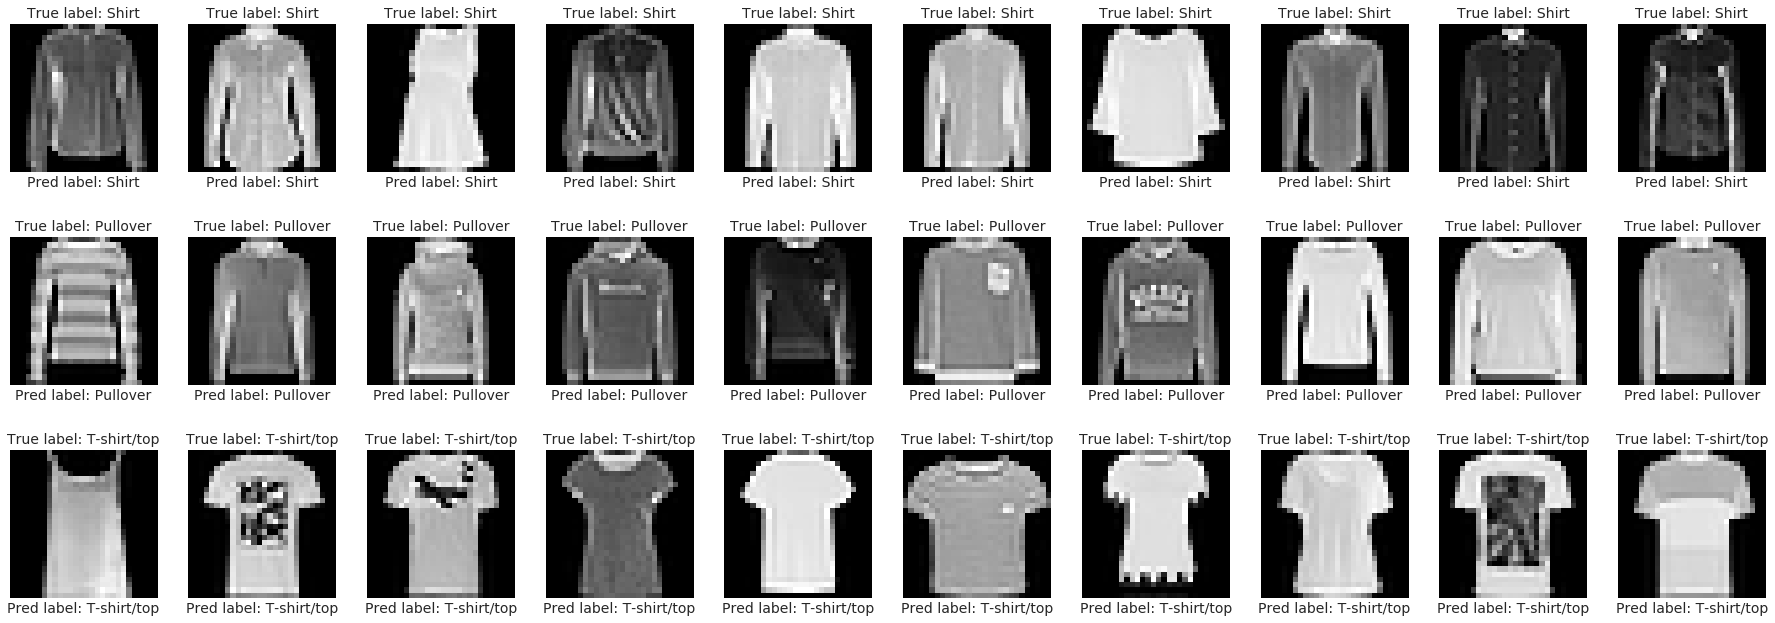

In [159]:
plot_imgs(s.CASTable('lenet_scored'), class_list=[6,2,0], query_condition='_label_ = _DL_PredName_',
          images_per_class=10, figsize=(25,10), font_size=14)

##### A few incorrect predictions at random - classes 6, 2, 0

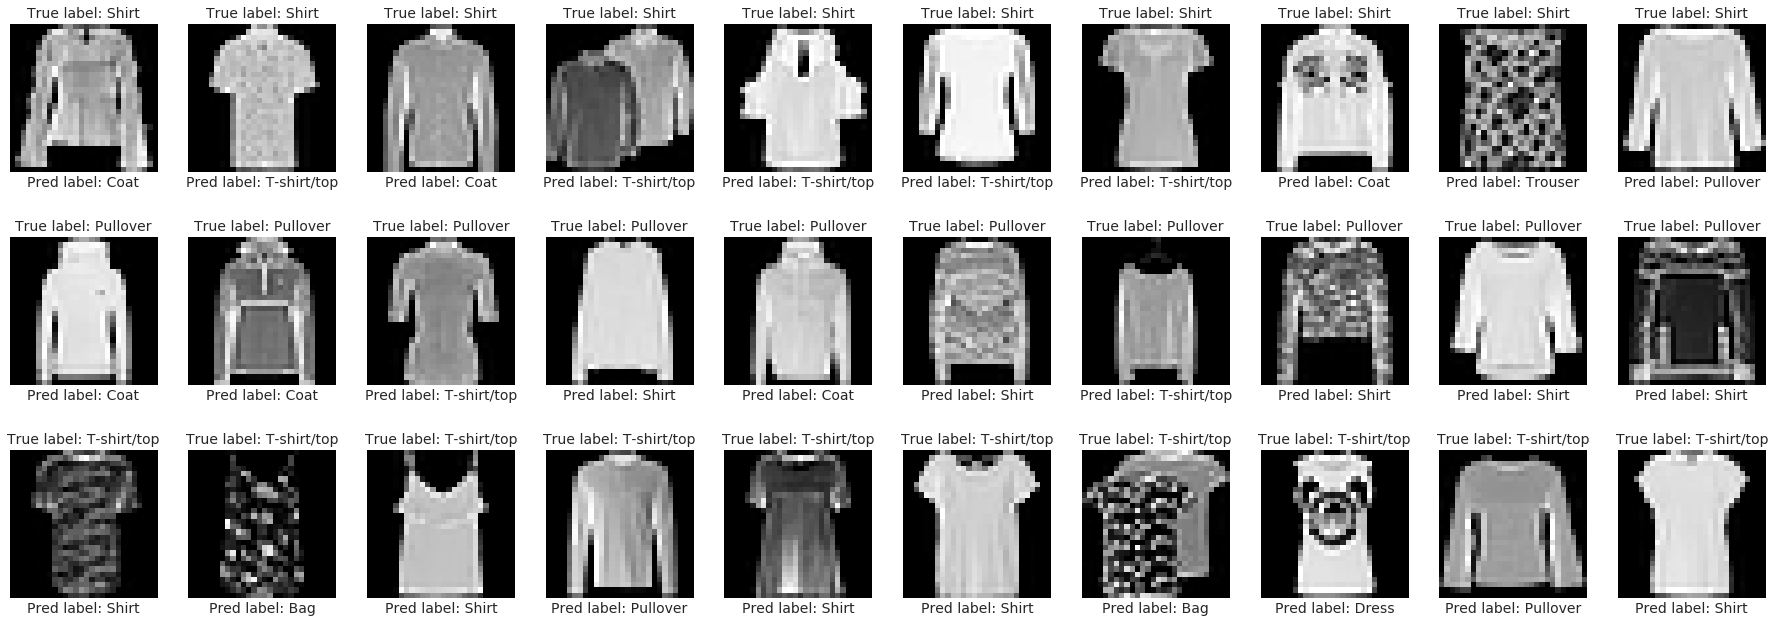

In [152]:
plot_imgs(s.CASTable('lenet_scored'), class_list=[6,2,0], query_condition='_label_ ^= _DL_PredName_',
          images_per_class=10, figsize=(25,10), font_size=14)

#####   The most correct predictions for class6 images

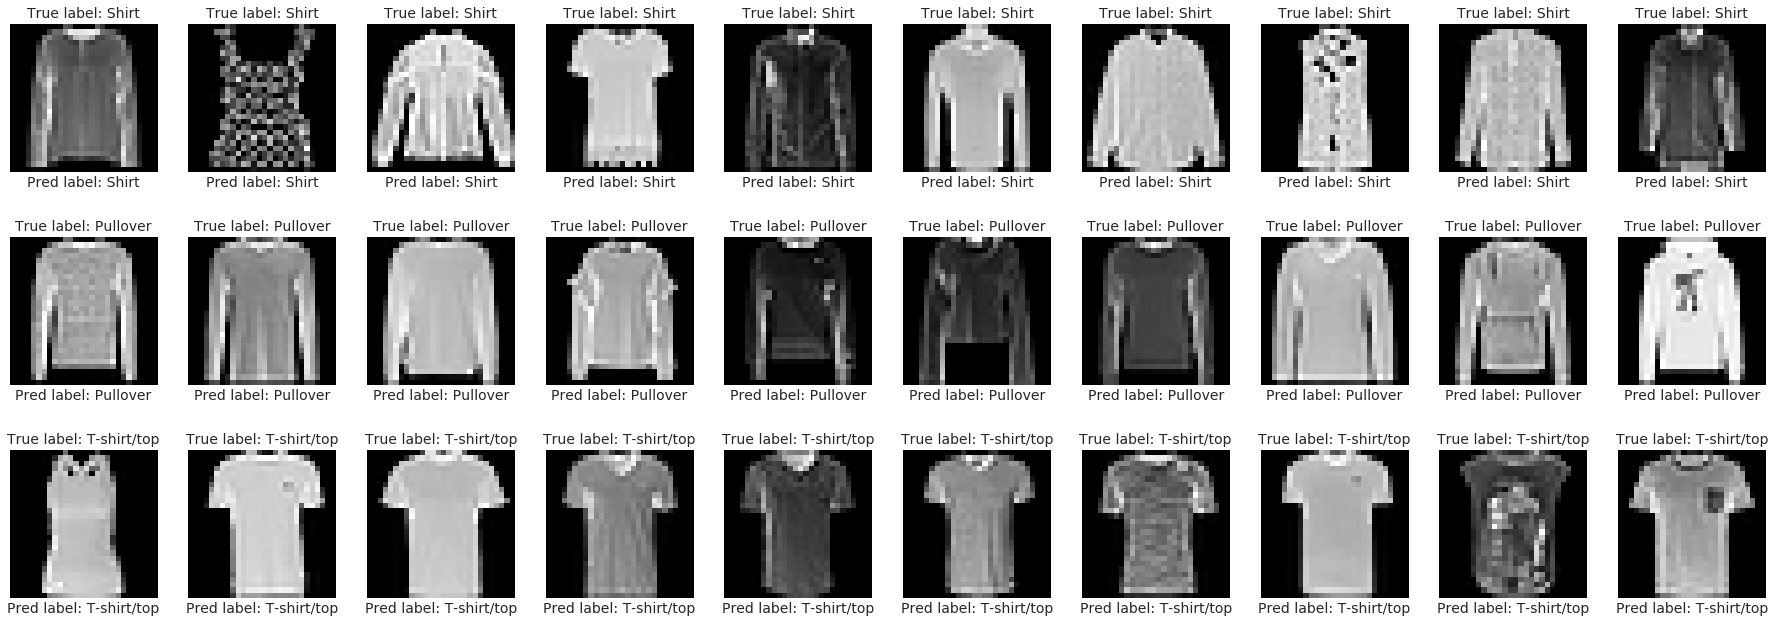

In [160]:
plot_imgs(s.CASTable('lenet_scored'),class_list=[6,2,0], query_condition='_label_ = _DL_PredName_ and _DL_PredP_ > 0.9',
          images_per_class=10, figsize=(25,10),font_size=14)

##### The most incorrect predictions for class6 images

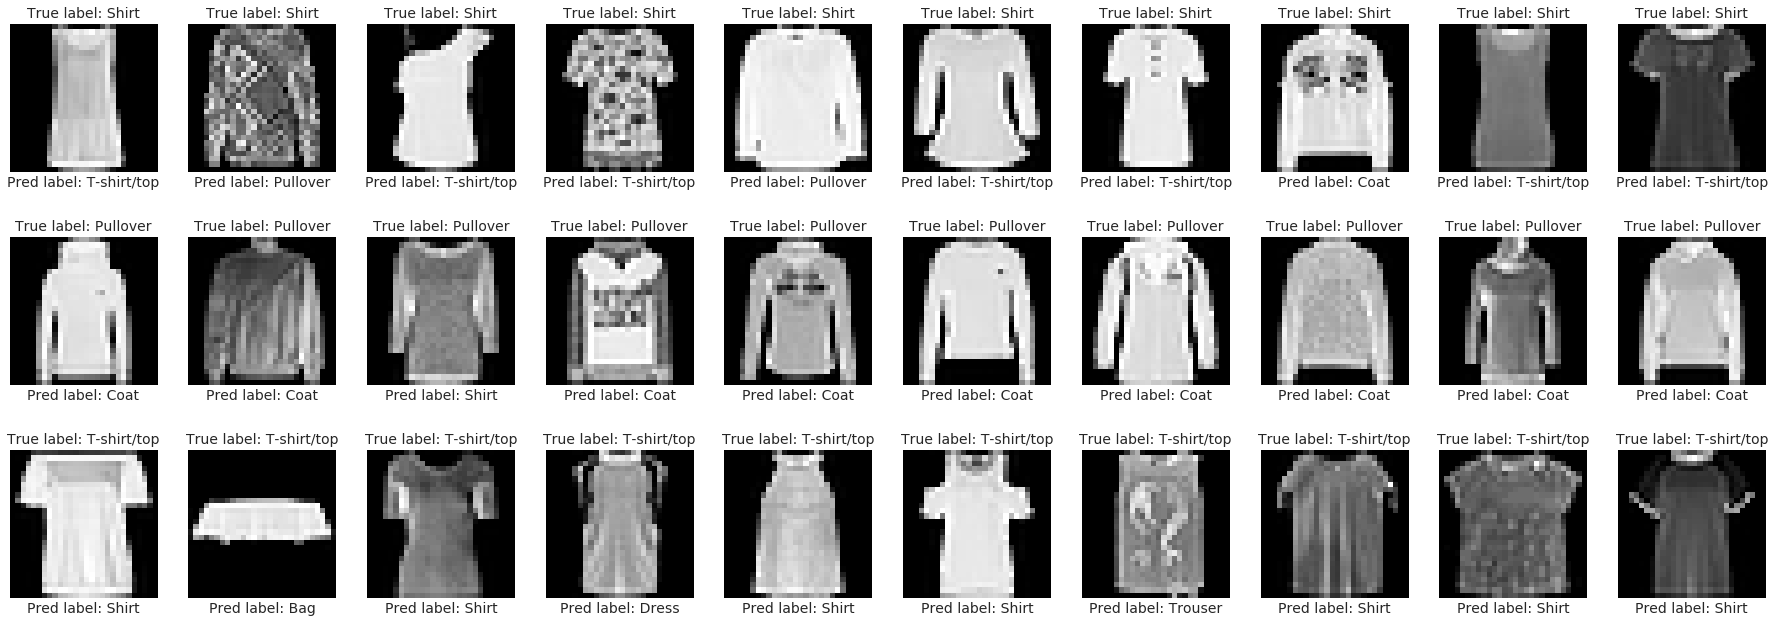

In [161]:
plot_imgs(s.CASTable('lenet_scored'),class_list=[6,2,0], query_condition='_label_ ^= _DL_PredName_ and _DL_PredP_ > 0.9',
          images_per_class=10, figsize=(25,10),font_size=14)

### Conv walk through

In [178]:
layeroutTbl=s.CASTable('layerout',replace=True)
layeroutTbl.fetch()['Fetch']

,_image_,_label_,_LayerAct_0_IMG_0_,_LayerAct_1_IMG_0_,_LayerAct_1_IMG_1_,_LayerAct_1_IMG_2_,_LayerAct_1_IMG_3_,_LayerAct_1_IMG_4_,_LayerAct_1_IMG_5_,_LayerAct_1_IMG_6_,...,_LayerAct_4_IMG_42_,_LayerAct_4_IMG_43_,_LayerAct_4_IMG_44_,_LayerAct_4_IMG_45_,_LayerAct_4_IMG_46_,_LayerAct_4_IMG_47_,_LayerAct_4_IMG_48_,_LayerAct_4_IMG_49_,_LayerAct_5_IMG_0_,_LayerAct_6_IMG_0_
0,         ������                  �������U...,class0,���� JFIF      �� C ...,���� JFIF      �� C ...,���� JFIF      �� C ...,���� JFIF      �� C ...,���� JFIF      �� C ...,���� JFIF      �� C ...,���� JFIF      �� C ...,���� JFIF      �� C ...,...,���� JFIF      �� C ...,���� JFIF      �� C ...,���� JFIF      �� C ...,���� JFIF      �� C ...,���� JFIF      �� C ...,���� JFIF      �� C ...,���� JFIF      �� C ...,���� JFIF      �� C ...,���� JFIF      �� C ...,���� JFIF      �� C ...
1,         s�f<;b�y                 |���������...,class3,���� JFIF      �� C ...,���� JFIF      �� C ...,���� JFIF      �� C ...,���� JFIF      �� C ...,���� JFIF      �� C ...,���� JFIF      �� C ...,���� JFIF      �� C ...,���� JFIF      �� C ...,...,���� JFIF      �� C ...,���� JFIF      �� C ...,���� JFIF      �� C ...,���� JFIF      �� C ...,���� JFIF      �� C ...,���� JFIF      �� C ...,���� JFIF      �� C ...,���� JFIF      �� C ...,���� JFIF      �� C ...,���� JFIF      �� C ...
2,        %�M  ��               \�������ܵ...,class0,���� JFIF      �� C ...,���� JFIF      �� C ...,���� JFIF      �� C ...,���� JFIF      �� C ...,���� JFIF      �� C ...,���� JFIF      �� C ...,���� JFIF      �� C ...,���� JFIF      �� C ...,...,���� JFIF      �� C ...,���� JFIF      �� C ...,���� JFIF      �� C ...,���� JFIF      �� C ...,���� JFIF      �� C ...,���� JFIF      �� C ...,���� JFIF      �� C ...,���� JFIF      �� C ...,���� JFIF      �� C ...,���� JFIF      �� C ...
3,                                              ...,class5,���� JFIF      �� C ...,���� JFIF      �� C ...,���� JFIF      �� C ...,���� JFIF      �� C ...,���� JFIF      �� C ...,���� JFIF      �� C ...,���� JFIF      �� C ...,���� JFIF      �� C ...,...,���� JFIF      �� C ...,���� JFIF      �� C ...,���� JFIF      �� C ...,���� JFIF      �� C ...,���� JFIF      �� C ...,���� JFIF      �� C 

In [179]:
layeroutTbl.fetchimages(image='_LayerAct_0_IMG_0_')['Images'].iloc[0][0]

In [180]:
layeroutTbl.fetchimages(image='_LayerAct_1_IMG_0_',to=100)['Images'].iloc[0][0]

In [181]:
layeroutTbl.fetchimages(image='_LayerAct_3_IMG_0_',to=100)['Images'].iloc[0][0]

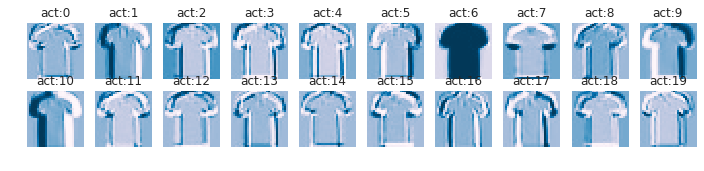

In [187]:
fig=plt.figure(figsize=(12, 6))
for i in range(20):
    w=np.asarray(layeroutTbl.fetchimages(image='_LayerAct_1_IMG_{}_'.format(i))['Images'].iloc[0][0])
    b=fig.add_subplot(5,10,i+1)
    plt.imshow(w, cmap='PuBu')
    plt.title('act:{}'.format(i))
    plt.axis('off')

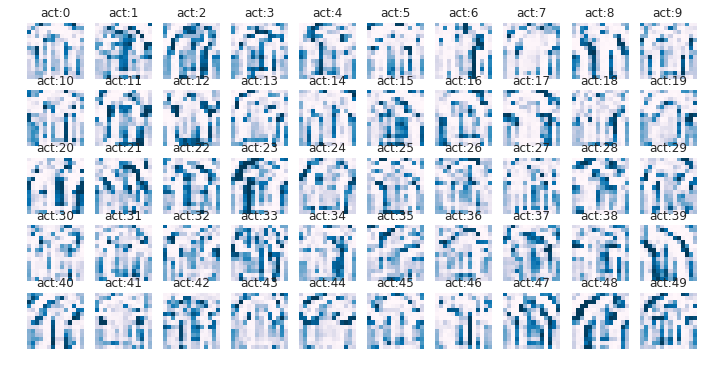

In [188]:
fig=plt.figure(figsize=(12, 6))
for i in range(50):
    w=np.asarray(layeroutTbl.fetchimages(image='_LayerAct_3_IMG_{}_'.format(i))['Images'].iloc[0][0])
    b=fig.add_subplot(5,10,i+1)
    plt.imshow(w, cmap='PuBu')
    plt.title('act:{}'.format(i))
    plt.axis('off')

In [ ]:
s.endsession()